<a href="https://colab.research.google.com/github/michaelsouliman/cs_145_final/blob/main/cs_145_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CS145: Project 3 | Analyzing The Metrics That Maximize Visbility on StackOverflow

## Collaborators:
Please list the names and SUNet IDs of your collaborators below:
* *Michael Souliman, msoul*
* *Ahmed Sharaf, ammas*

## Project Overview

---

The main question that we are trying to answer is "What metrics maximize visibility on StackOverflow?". We are going to analyze different metrics for each post on the platform, including:

*   date/time the post was created
*   length of the title
*   the number of tags on a post
*   the reputation of the user that posted
*   if a user is new
*   number of times a post has been edited

We are going to relate these metrics to the posts' popularity (view counts) to see if there is any correlation and if so, how strong that correlation is.

In addition to these metrics for the posts themselves, we are going to simlarly analyze the following metrics for the verified answers:
 *   how long after the post was made was that answer posted
 *   length of the answer
 *   the badges that the user that posted the answer has
 *   the reputation of the user that posted
 *   the number of users that the person who posted the answer has reached

We are going to relate these metrics to the answers' credibility (score) to see if there is any correlation between them.

The two main subquestions that we are going to explore are: 
*   What metrics most effect the popularity of a post?
*   What metrics most effect the credibility of an answer?

Using the metrics we see to have a correlation with visibility and credibility, we will use the data set to try and predict if the view count of a certain post is above or below the mean view count and if a certain answer going to be chosen as the accepted answer for that post.

---


## Analysis of Dataset

---
Dataset Summary

We have 5 tables in one dataset (`bigquery-public-data.stackoverflow`):
*   `badges` (1.96 GB) : Table of all badges awarded to a user on StackOverflow
*   `posts_answers` (28.62 GB): Table of all accepted answers for posts on StackOverflow 
*   `stackoverflow_posts` (29.36 GB): Table of all posts on StackOverflow, including the content of the post itself and the id of the accepted answer for that post
*   `users` (3.14 GB): Table of all users and their data (reputation, location, up/down votes, etc)
*   `posts_history` (32.85 GB): Table of all edits made on all posts on StackOverflow

which total **95.93** GB of data.

**Badges** 

The `badges` table contains information on the badges that a user has. Each row in the table contains the name of the badge, the user that has that badge, and the date that the user aquired the badge. One way we plan on utilizing this table is by grouping on `user_id` to get all of the badges that a user. We will bucket the tiers of the badges and use them to assign each user a `user_score` and track the average scores on answers for each `user_score`. This we can use to see how badges effect credibility for users (votes).

There is the primary key `id` that signifies one badge for one user, but we will not be using this key to join on any other tables. We will also not be joining on `user_id` but we need to group by this column to get all of the badges that a user has and the class of that badge (bronze, silver, or gold).

**Posts Answers**

The `posts_answers` table contains information on the answers for each post. Each row contains the `id` of that answer along with the contents of the answer itself, the user that posted it, and the time the answer was posted. We plan on joining with the `users` table to relate metrics like the length of the answer to the badges a user has, their reputation, and the number of useres that their answers have reached. This table contains all answers, not just the accepted answers. We are using all answers because a person may select an answer as accepted, but then another user can post another answer that is better and that answer will have a higher score. Because our aim is to measure overall credibility, we will look at all answers and not just accepted answers.

For this table, there is the primary key `id`. We will use this to join with the `stackoverflow_posts` table to get if the answer is the accepted answer for the post it's on. We will use this information to create the dataset for our model to predict if a post is the accepted answer or not.

**StackOverflow Posts**

The `stackoverflow_posts` table contains information on all posts on StackOverflow, including their view count, user who posted, the id of the accepted answer, the tags used on the post, etc. We plan on using this table with almost all of the other tables in this list to calculate how metrics like the length of the title, the tags on the post, and the time the post was created relate to the popularity (`view_count`).

For this table, we will be using the following keys to join with other tables:
*   `accepted_answer_id` : This is a foreign key (primary key `id` in `posts_answers`) that we will be using to determine if an answer is accepted or not.
*   `owner_user_id` : This is a foreign key (primary key `id` in `users`) that we will use to get the user info for each post (user's reputation, difference in time between the creation of a post and the creation of the account that posted it)

**Users**

The `users` table contains information on all users on StackOverflow, including their total up/down votes, reputation, views, and their `id` which we can use to join with other tables, such as the `stackoverflow_posts` and `post_answers` as described above.

Here, we will use the primary key `id` to join with other tables as described in the other parts of this analysis.

**Post History**

The `post_history` table contains information on all of the posts on StackOverflow, inlcuding the changes the user made to the post, the time the edit was made, the user who made the edit, and any comments the user had on the edit they made. This table we can use to count the number of times a post was edited and see how the number of edits effects the visibility of a post. While we will not be measuring anything relating to how the structure of the post changes, being able to count the number of edits may be an important metric (assuming that a user edits the post to make it so that the question is more clear).

Here, we have the primary key `id` that we will not be using. Instead, we will be using the column `post_id` to group by and count the number of edits on a post. We will not be joining this table with any other tables.

----

## Data Exploration

In [ ]:
# Run this cell to authenticate yourself to BigQuery
from google.colab import auth
auth.authenticate_user()
project_id = "cs145-fall22-msoul"

In [ ]:
# Initialize BiqQuery client
from google.cloud import bigquery
client = bigquery.Client(project=project_id)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

---
**Analysis of Metrics on StackOverflow Posts**

In this section, we will be analyzing 6 key metrics on the posts on StackOverflow and relate them to that post's view count, a measure of that questions popularity and the visibility that question had on the platform.

---

---
**Metric 1: Post Time**

Here, we will analyze how the time that a post was created on StackOverflow effects that post's visibility, which we will measure using the view count of that post. The following query returns a table with the time a post was created and the view count of that post. Both of these fields are in the `stackoverflow_posts` table, with the columns we are focusing on being `creation_date` and `view_count`. To ensure that we have a complete dataset to plot, we are going to exclude any rows that have either field as NULL. Once we have the `creation_date`, we are going to map that date to the time of day it was posted in UTC time, with 0 being 12 AM and 86399 being 11:59:59 PM. 

---

In [ ]:
%%bigquery post_time_df --project $project_id 

SELECT
  (EXTRACT(second
    FROM
      creation_date) + (EXTRACT(minute
      FROM
        creation_date) * 60) + (EXTRACT(hour
      FROM
        creation_date) * 3600)) AS second_of_the_day,
  view_count
FROM
  `bigquery-public-data.stackoverflow.stackoverflow_posts`
WHERE
  creation_date IS NOT NULL
  AND view_count IS NOT NULL
ORDER BY 
  RAND()
LIMIT
  10000

Query is running:   0%|          |

Downloading:   0%|          |

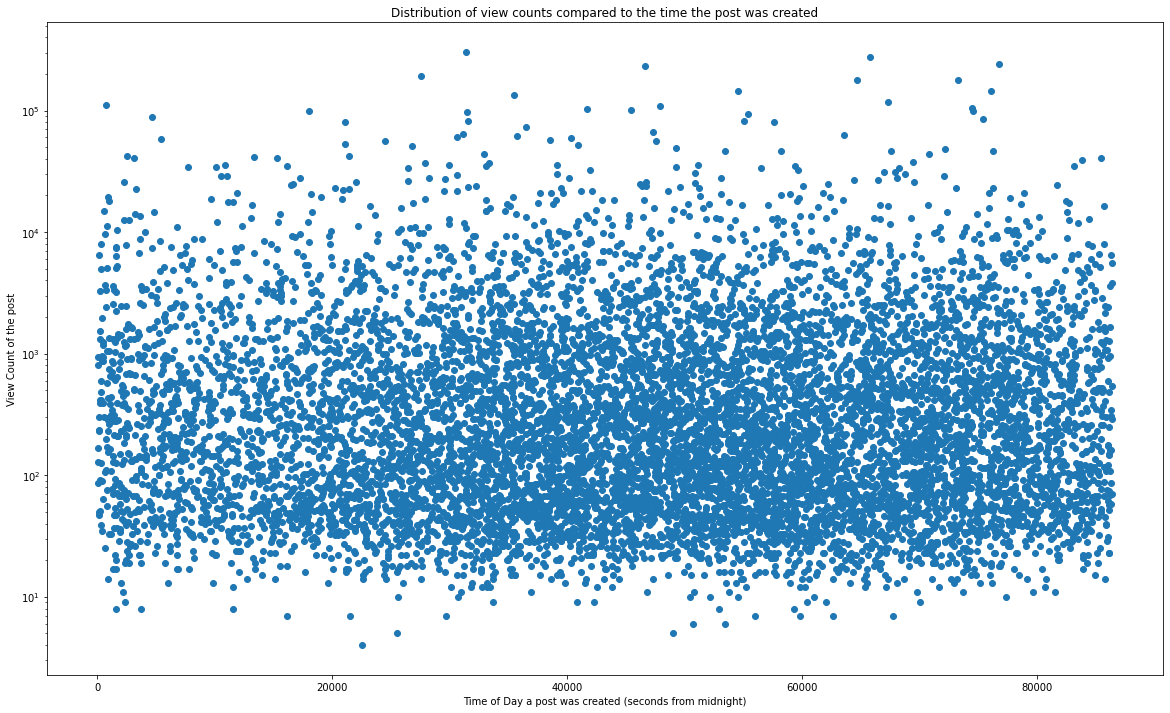

In [ ]:
plt.figure(1, [20,12])
plt.scatter(post_time_df["second_of_the_day"], post_time_df["view_count"])
plt.title("Distribution of view counts compared to the time the post was created")
plt.xlabel("Time of Day a post was created (seconds from midnight)")
plt.ylabel("View Count of the post")
plt.yscale("log")

---
Result:
As seen in the visualization above, there seems to be no correlation between the view count of a given post and the time that the post was created. Intitively, this makes sense because the website is used by people from all around the world and there are people constantly posting on the website. There will always be a region of the world using the website so we did not expect to have this metric be one that we use to train our model.

One idea we wanted to explore was graphing based on the location of the user that posted, but unfortunately in the `users` table, the location graph is a string that is not well formed for all regions (no way to extract the user's region from the string using SQL) so we decided to exclude this metric from the data we used to train the model.

---

---
**Metric 2: Length of the title**

Here, we will analyze how the length of the title of a post on StackOverflow effects that post's visibility. The following query returns a table that has a row for each row in the `stackoverflow_posts` along with the following information:
*   the length of the title of that post
*   the view count of that post

Here, we ensure that we have a good dataset by excluding any posts that either don't have a value for their `title` listed or don't have a value for their `view_count` listed.

---

In [ ]:
%%bigquery post_length_df --project $project_id 

SELECT
  LENGTH(title) AS title_length,
  view_count
FROM
  `bigquery-public-data.stackoverflow.stackoverflow_posts`
WHERE
  title IS NOT NULL
  AND view_count IS NOT NULL

Query is running:   0%|          |

Downloading:   0%|          |

Text(0, 0.5, 'View Count of the post')

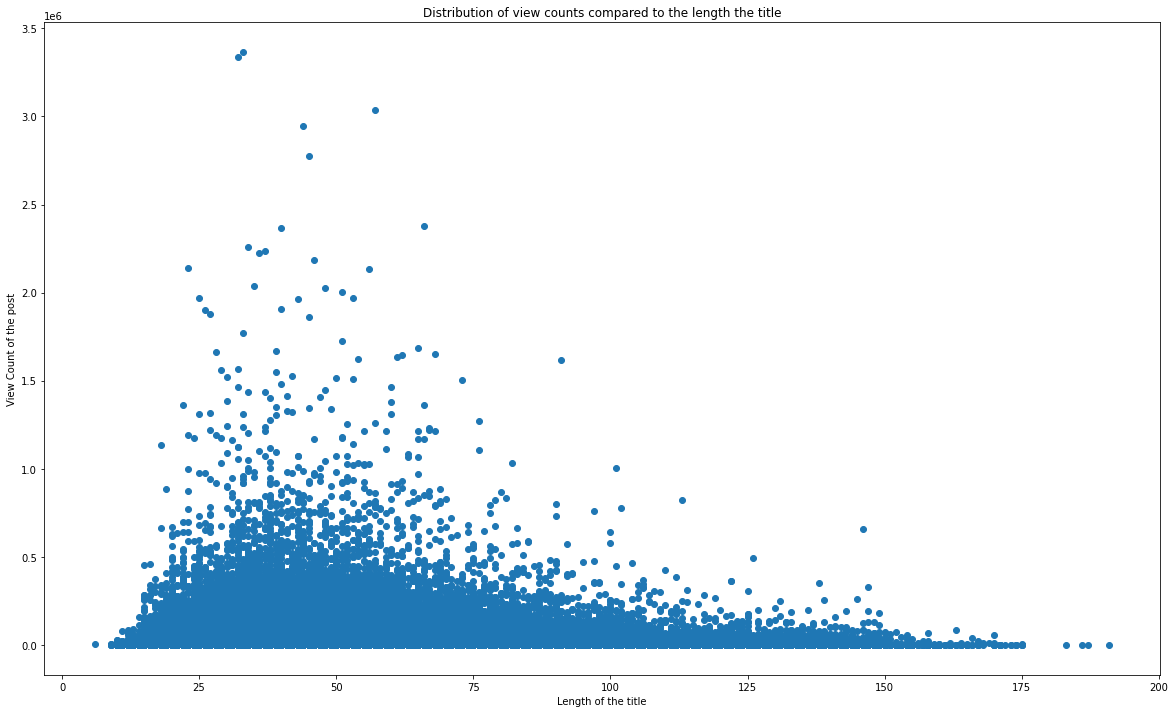

In [ ]:
plt.figure(1, [20,12])
plt.scatter(post_length_df["title_length"], post_length_df["view_count"])
plt.title("Distribution of view counts compared to the length the title")
plt.xlabel("Length of the title")
plt.ylabel("View Count of the post")

---
Results:
As seen in the visualization above, we see a slight correlation between the length of the title and the `view_count` of the post, where the posts that are seen to have the highest visibility are roughly between 40 and 60 characters long. This distribution is unimodal so we have enough correlation that we are going to add it to the data set we use to train and test the model. While the correlation is not the strongest, we predict that the weight that his node in our input layer will still be significant.


---

---
**Metric 3: Tags on a post**

Here, we will analyze how the tags a user adds to a post on StackOverflow effects that post's visibility. The first query below gets the running total of the average view counts of each tag, ordered in decending order of view counts. We have assigned a unique id for every tag. The first visualization shows how the buckets will be divided and the second though the sixth visualizations show the average `view_count` based on the number of tags in each bucket. The second gets the distribution of `view_counts` based on the number of tags that a post has in that bucket. 

For example, if a post had 3 tags (2 in the 1st bucket and 1 in the 3rd bucket), in our second visualization we would add the `view_count` of that post the the bar representing posts that had 2 tags in that top bucket and in our fourth visualization we would add the `view_count` of that post to the bar corresponding to posts that have 1 tag in that 3rd bucket.

---

In [ ]:
%%bigquery num_tags_df --project $project_id 

SELECT
  id,
  SUM (avg_vc) OVER (ORDER BY id) AS total
FROM (
  SELECT
    DISTINCT tag,
    AVG(view_count) AS avg_vc,
    ROW_NUMBER() OVER(ORDER BY AVG(view_count) DESC) AS id
  FROM (
    SELECT
      SPLIT(tags, "|") AS tags_array,
      view_count
    FROM
      `bigquery-public-data.stackoverflow.stackoverflow_posts`
    WHERE
      tags IS NOT NULL
      AND tags != ""
      AND view_count IS NOT NULL) posts_tags
  CROSS JOIN
    UNNEST(posts_tags.tags_array) AS tag
  GROUP BY
    tag
  ORDER BY
    avg_vc DESC)

Query is running:   0%|          |

Downloading:   0%|          |

Text(0, 0.5, 'Running total of the average view count on posts with that tag')

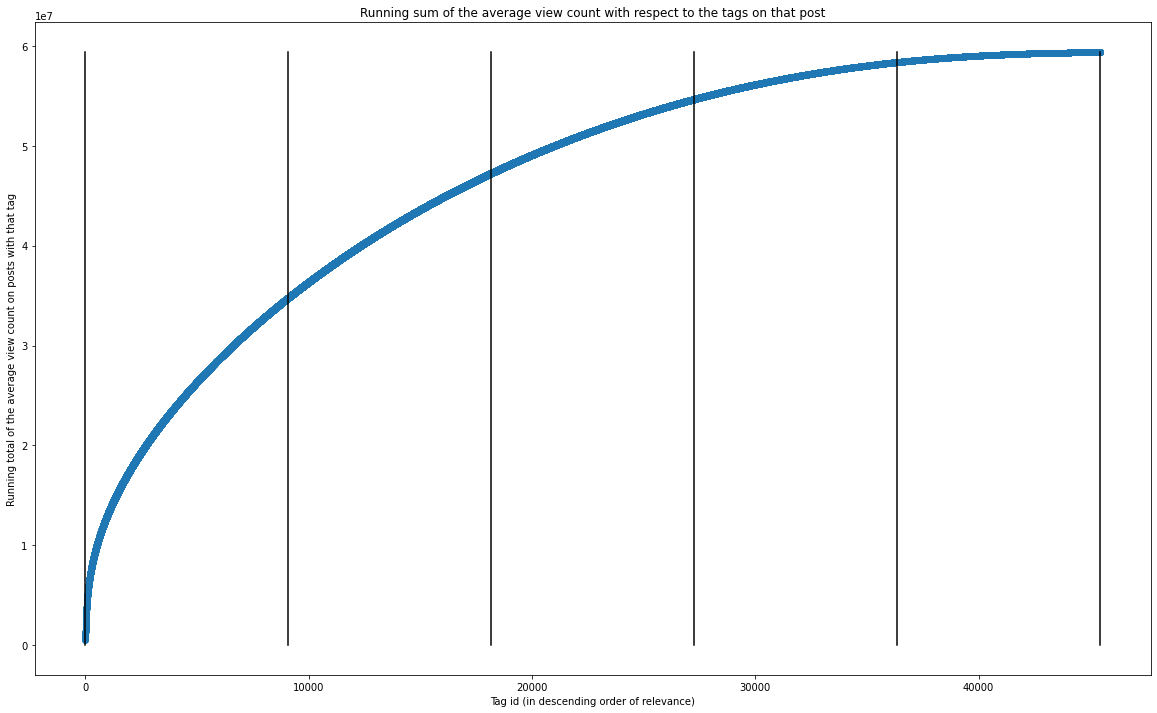

In [ ]:
plt.figure(1, [20,12])
plt.scatter(num_tags_df["id"], num_tags_df["total"])
plt.plot([0, 0],[0, 59383845], 'k-')
plt.plot([9085, 9085],[0, 59383845], 'k-')
plt.plot([2*9085, 2*9085],[0, 59383845], 'k-')
plt.plot([3*9085, 3*9085],[0, 59383845], 'k-')
plt.plot([4*9085, 4*9085],[0, 59383845], 'k-')
plt.plot([5*9085, 5*9085],[0, 59383845], 'k-')
plt.title("Running sum of the average view count with respect to the tags on that post")
plt.xlabel("Tag id (in descending order of relevance)")
plt.ylabel("Running total of the average view count on posts with that tag")

In [ ]:
%%bigquery tags_dist_df --project $project_id 
#This is the tags_master table, which contains the `view_count` for each post and the number of tags it has in each bucket
WITH
  t1 AS (
  SELECT
    tags_dist.id AS tag_id,
    post_tags.id AS post_id
  FROM (
    SELECT
      DISTINCT tag,
      AVG(view_count) AS avg_vc,
      ROW_NUMBER() OVER(ORDER BY AVG(view_count) DESC) AS id
    FROM (
      SELECT
        SPLIT(tags, "|") AS tags_array,
        view_count
      FROM
        `bigquery-public-data.stackoverflow.stackoverflow_posts`
      WHERE
        tags IS NOT NULL
        AND tags != ""
        AND view_count IS NOT NULL) posts_tags
    CROSS JOIN
      UNNEST(posts_tags.tags_array) AS tag
    GROUP BY
      tag
    ORDER BY
      avg_vc DESC ) tags_dist
  RIGHT OUTER JOIN (
    SELECT
      id,
      tag,
      view_count
    FROM (
      SELECT
        id,
        SPLIT(tags, "|") AS tags_array,
        view_count
      FROM
        `bigquery-public-data.stackoverflow.stackoverflow_posts`
      WHERE
        tags IS NOT NULL
        AND tags != ""
        AND view_count IS NOT NULL) posts_tags
    CROSS JOIN
      UNNEST(posts_tags.tags_array) AS tag
    ORDER BY
      id) post_tags
  ON
    tags_dist.tag = post_tags.tag)
SELECT
  posts.view_count,
  (
  SELECT
    COUNT(*)
  FROM
    t1
  WHERE
    t1.post_id = posts.id
    AND t1.tag_id < 9085) AS tags_1,
  (
  SELECT
    COUNT(*)
  FROM
    t1
  WHERE
    t1.post_id = posts.id
    AND t1.tag_id < 2*9085
    AND t1.tag_id >= 9085) AS tags_2,
  (
  SELECT
    COUNT(*)
  FROM
    t1
  WHERE
    t1.post_id = posts.id
    AND t1.tag_id < 3*9085
    AND t1.tag_id >= 2*9085) AS tags_3,
  (
  SELECT
    COUNT(*)
  FROM
    t1
  WHERE
    t1.post_id = posts.id
    AND t1.tag_id < 4*9085
    AND t1.tag_id >= 3*9085) AS tags_4,
  (
  SELECT
    COUNT(*)
  FROM
    t1
  WHERE
    t1.post_id = posts.id
    AND t1.tag_id >= 4*9085) AS tags_5,
FROM
  `bigquery-public-data.stackoverflow.stackoverflow_posts` posts
WHERE
  title IS NOT NULL
  AND view_count IS NOT NULL

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
%%bigquery tags1_dist_df --project $project_id 


WITH
  tags_master AS (
  WITH
    t1 AS (
    SELECT
      tags_dist.id AS tag_id,
      post_tags.id AS post_id
    FROM (
      SELECT
        DISTINCT tag,
        AVG(view_count) AS avg_vc,
        ROW_NUMBER() OVER(ORDER BY AVG(view_count) DESC) AS id
      FROM (
        SELECT
          SPLIT(tags, "|") AS tags_array,
          view_count
        FROM
          `bigquery-public-data.stackoverflow.stackoverflow_posts`
        WHERE
          tags IS NOT NULL
          AND tags != ""
          AND view_count IS NOT NULL) posts_tags
      CROSS JOIN
        UNNEST(posts_tags.tags_array) AS tag
      GROUP BY
        tag
      ORDER BY
        avg_vc DESC ) tags_dist
    RIGHT OUTER JOIN (
      SELECT
        id,
        tag,
        view_count
      FROM (
        SELECT
          id,
          SPLIT(tags, "|") AS tags_array,
          view_count
        FROM
          `bigquery-public-data.stackoverflow.stackoverflow_posts`
        WHERE
          tags IS NOT NULL
          AND tags != ""
          AND view_count IS NOT NULL) posts_tags
      CROSS JOIN
        UNNEST(posts_tags.tags_array) AS tag
      ORDER BY
        id) post_tags
    ON
      tags_dist.tag = post_tags.tag)
  SELECT
    posts.view_count,
    (
    SELECT
      COUNT(*)
    FROM
      t1
    WHERE
      t1.post_id = posts.id
      AND t1.tag_id < 9085) AS tags_1,
    (
    SELECT
      COUNT(*)
    FROM
      t1
    WHERE
      t1.post_id = posts.id
      AND t1.tag_id < 2*9085
      AND t1.tag_id >= 9085) AS tags_2,
    (
    SELECT
      COUNT(*)
    FROM
      t1
    WHERE
      t1.post_id = posts.id
      AND t1.tag_id < 3*9085
      AND t1.tag_id >= 2*9085) AS tags_3,
    (
    SELECT
      COUNT(*)
    FROM
      t1
    WHERE
      t1.post_id = posts.id
      AND t1.tag_id < 4*9085
      AND t1.tag_id >= 3*9085) AS tags_4,
    (
    SELECT
      COUNT(*)
    FROM
      t1
    WHERE
      t1.post_id = posts.id
      AND t1.tag_id >= 4*9085) AS tags_5,
  FROM
    `bigquery-public-data.stackoverflow.stackoverflow_posts` posts
  WHERE
    title IS NOT NULL
    AND view_count IS NOT NULL)
SELECT
  tags_1,
  AVG(view_count) as avg_vc
FROM
  tags_master
GROUP BY
  tags_1

Query is running:   0%|          |

Downloading:   0%|          |

Text(0, 0.5, 'Average View Count of the post')

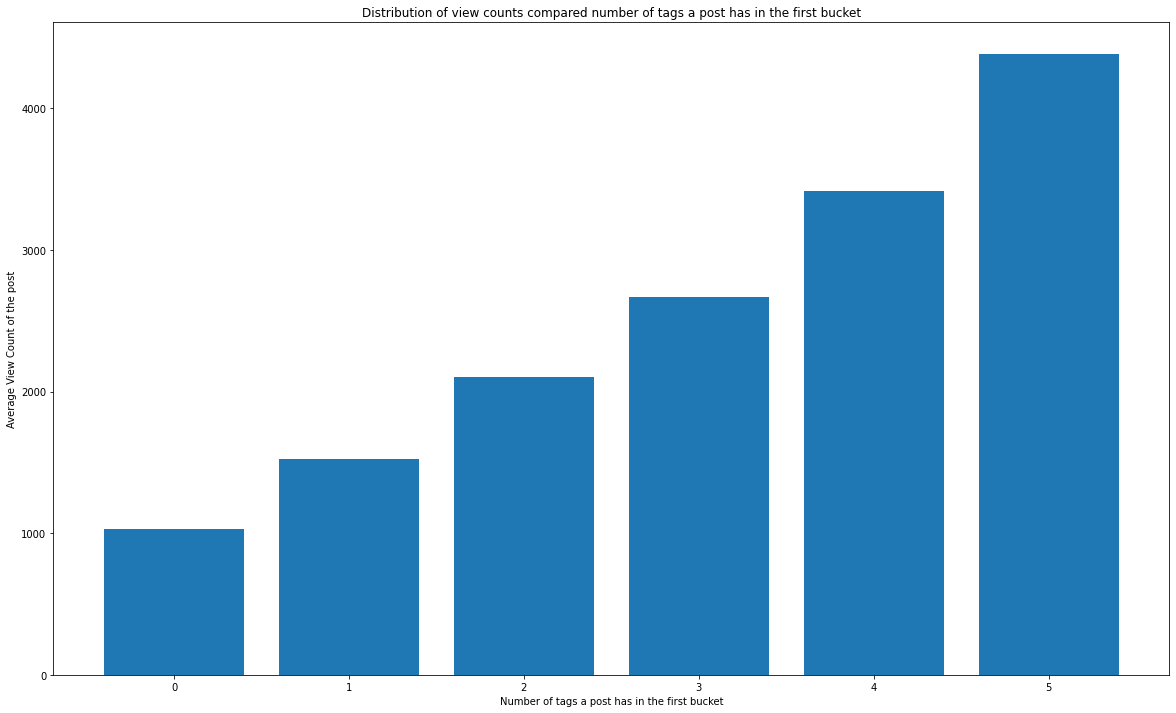

In [ ]:
plt.figure(1, [20,12])
plt.bar(tags1_dist_df["tags_1"], tags1_dist_df["avg_vc"])
plt.title("Distribution of view counts compared number of tags a post has in the first bucket")
plt.xlabel("Number of tags a post has in the first bucket")
plt.ylabel("Average View Count of the post")

In [ ]:
%%bigquery tags2_dist_df --project $project_id 

WITH
  tags_master AS (
  WITH
    t1 AS (
    SELECT
      tags_dist.id AS tag_id,
      post_tags.id AS post_id
    FROM (
      SELECT
        DISTINCT tag,
        AVG(view_count) AS avg_vc,
        ROW_NUMBER() OVER(ORDER BY AVG(view_count) DESC) AS id
      FROM (
        SELECT
          SPLIT(tags, "|") AS tags_array,
          view_count
        FROM
          `bigquery-public-data.stackoverflow.stackoverflow_posts`
        WHERE
          tags IS NOT NULL
          AND tags != ""
          AND view_count IS NOT NULL) posts_tags
      CROSS JOIN
        UNNEST(posts_tags.tags_array) AS tag
      GROUP BY
        tag
      ORDER BY
        avg_vc DESC ) tags_dist
    RIGHT OUTER JOIN (
      SELECT
        id,
        tag,
        view_count
      FROM (
        SELECT
          id,
          SPLIT(tags, "|") AS tags_array,
          view_count
        FROM
          `bigquery-public-data.stackoverflow.stackoverflow_posts`
        WHERE
          tags IS NOT NULL
          AND tags != ""
          AND view_count IS NOT NULL) posts_tags
      CROSS JOIN
        UNNEST(posts_tags.tags_array) AS tag
      ORDER BY
        id) post_tags
    ON
      tags_dist.tag = post_tags.tag)
  SELECT
    posts.view_count,
    (
    SELECT
      COUNT(*)
    FROM
      t1
    WHERE
      t1.post_id = posts.id
      AND t1.tag_id < 9085) AS tags_1,
    (
    SELECT
      COUNT(*)
    FROM
      t1
    WHERE
      t1.post_id = posts.id
      AND t1.tag_id < 2*9085
      AND t1.tag_id >= 9085) AS tags_2,
    (
    SELECT
      COUNT(*)
    FROM
      t1
    WHERE
      t1.post_id = posts.id
      AND t1.tag_id < 3*9085
      AND t1.tag_id >= 2*9085) AS tags_3,
    (
    SELECT
      COUNT(*)
    FROM
      t1
    WHERE
      t1.post_id = posts.id
      AND t1.tag_id < 4*9085
      AND t1.tag_id >= 3*9085) AS tags_4,
    (
    SELECT
      COUNT(*)
    FROM
      t1
    WHERE
      t1.post_id = posts.id
      AND t1.tag_id >= 4*9085) AS tags_5,
  FROM
    `bigquery-public-data.stackoverflow.stackoverflow_posts` posts
  WHERE
    title IS NOT NULL
    AND view_count IS NOT NULL)
SELECT
  tags_2,
  AVG(view_count) as avg_vc
FROM
  tags_master
GROUP BY
  tags_2

Query is running:   0%|          |

Downloading:   0%|          |

Text(0, 0.5, 'Average View Count of the post')

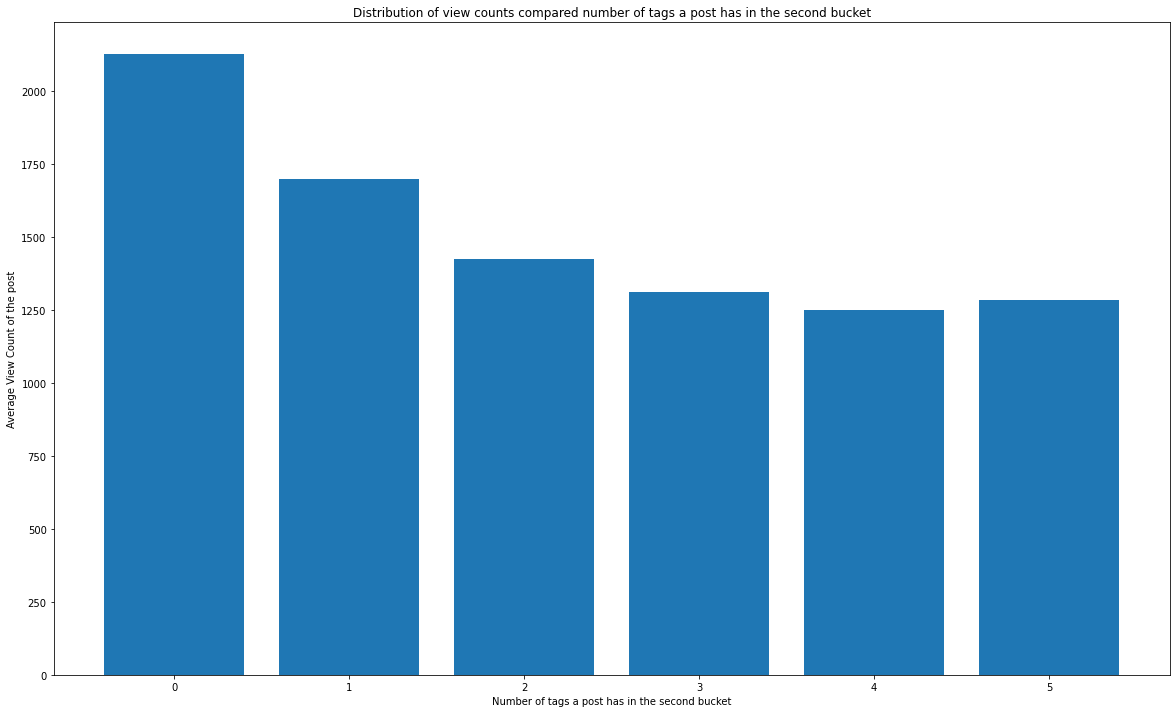

In [ ]:
plt.figure(1, [20,12])
plt.bar(tags2_dist_df["tags_2"], tags2_dist_df["avg_vc"])
plt.title("Distribution of view counts compared number of tags a post has in the second bucket")
plt.xlabel("Number of tags a post has in the second bucket")
plt.ylabel("Average View Count of the post")

In [ ]:
%%bigquery tags3_dist_df --project $project_id 

WITH
  tags_master AS (
  WITH
    t1 AS (
    SELECT
      tags_dist.id AS tag_id,
      post_tags.id AS post_id
    FROM (
      SELECT
        DISTINCT tag,
        AVG(view_count) AS avg_vc,
        ROW_NUMBER() OVER(ORDER BY AVG(view_count) DESC) AS id
      FROM (
        SELECT
          SPLIT(tags, "|") AS tags_array,
          view_count
        FROM
          `bigquery-public-data.stackoverflow.stackoverflow_posts`
        WHERE
          tags IS NOT NULL
          AND tags != ""
          AND view_count IS NOT NULL) posts_tags
      CROSS JOIN
        UNNEST(posts_tags.tags_array) AS tag
      GROUP BY
        tag
      ORDER BY
        avg_vc DESC ) tags_dist
    RIGHT OUTER JOIN (
      SELECT
        id,
        tag,
        view_count
      FROM (
        SELECT
          id,
          SPLIT(tags, "|") AS tags_array,
          view_count
        FROM
          `bigquery-public-data.stackoverflow.stackoverflow_posts`
        WHERE
          tags IS NOT NULL
          AND tags != ""
          AND view_count IS NOT NULL) posts_tags
      CROSS JOIN
        UNNEST(posts_tags.tags_array) AS tag
      ORDER BY
        id) post_tags
    ON
      tags_dist.tag = post_tags.tag)
  SELECT
    posts.view_count,
    (
    SELECT
      COUNT(*)
    FROM
      t1
    WHERE
      t1.post_id = posts.id
      AND t1.tag_id < 9085) AS tags_1,
    (
    SELECT
      COUNT(*)
    FROM
      t1
    WHERE
      t1.post_id = posts.id
      AND t1.tag_id < 2*9085
      AND t1.tag_id >= 9085) AS tags_2,
    (
    SELECT
      COUNT(*)
    FROM
      t1
    WHERE
      t1.post_id = posts.id
      AND t1.tag_id < 3*9085
      AND t1.tag_id >= 2*9085) AS tags_3,
    (
    SELECT
      COUNT(*)
    FROM
      t1
    WHERE
      t1.post_id = posts.id
      AND t1.tag_id < 4*9085
      AND t1.tag_id >= 3*9085) AS tags_4,
    (
    SELECT
      COUNT(*)
    FROM
      t1
    WHERE
      t1.post_id = posts.id
      AND t1.tag_id >= 4*9085) AS tags_5,
  FROM
    `bigquery-public-data.stackoverflow.stackoverflow_posts` posts
  WHERE
    title IS NOT NULL
    AND view_count IS NOT NULL)
SELECT
  tags_3,
  AVG(view_count) as avg_vc
FROM
  tags_master
GROUP BY
  tags_3

Query is running:   0%|          |

Downloading:   0%|          |

Text(0, 0.5, 'Average View Count of the post')

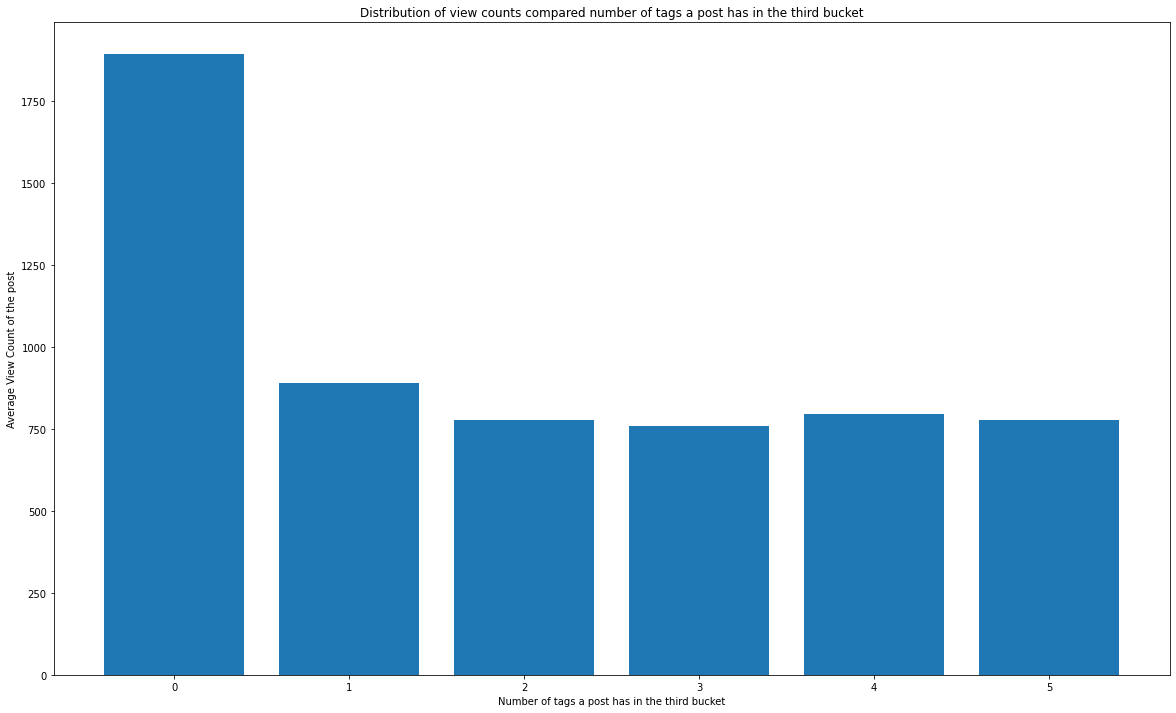

In [ ]:
plt.figure(1, [20,12])
plt.bar(tags3_dist_df["tags_3"], tags3_dist_df["avg_vc"])
plt.title("Distribution of view counts compared number of tags a post has in the third bucket")
plt.xlabel("Number of tags a post has in the third bucket")
plt.ylabel("Average View Count of the post")

In [ ]:
%%bigquery tags4_dist_df --project $project_id 

WITH
  tags_master AS (
  WITH
    t1 AS (
    SELECT
      tags_dist.id AS tag_id,
      post_tags.id AS post_id
    FROM (
      SELECT
        DISTINCT tag,
        AVG(view_count) AS avg_vc,
        ROW_NUMBER() OVER(ORDER BY AVG(view_count) DESC) AS id
      FROM (
        SELECT
          SPLIT(tags, "|") AS tags_array,
          view_count
        FROM
          `bigquery-public-data.stackoverflow.stackoverflow_posts`
        WHERE
          tags IS NOT NULL
          AND tags != ""
          AND view_count IS NOT NULL) posts_tags
      CROSS JOIN
        UNNEST(posts_tags.tags_array) AS tag
      GROUP BY
        tag
      ORDER BY
        avg_vc DESC ) tags_dist
    RIGHT OUTER JOIN (
      SELECT
        id,
        tag,
        view_count
      FROM (
        SELECT
          id,
          SPLIT(tags, "|") AS tags_array,
          view_count
        FROM
          `bigquery-public-data.stackoverflow.stackoverflow_posts`
        WHERE
          tags IS NOT NULL
          AND tags != ""
          AND view_count IS NOT NULL) posts_tags
      CROSS JOIN
        UNNEST(posts_tags.tags_array) AS tag
      ORDER BY
        id) post_tags
    ON
      tags_dist.tag = post_tags.tag)
  SELECT
    posts.view_count,
    (
    SELECT
      COUNT(*)
    FROM
      t1
    WHERE
      t1.post_id = posts.id
      AND t1.tag_id < 9085) AS tags_1,
    (
    SELECT
      COUNT(*)
    FROM
      t1
    WHERE
      t1.post_id = posts.id
      AND t1.tag_id < 2*9085
      AND t1.tag_id >= 9085) AS tags_2,
    (
    SELECT
      COUNT(*)
    FROM
      t1
    WHERE
      t1.post_id = posts.id
      AND t1.tag_id < 3*9085
      AND t1.tag_id >= 2*9085) AS tags_3,
    (
    SELECT
      COUNT(*)
    FROM
      t1
    WHERE
      t1.post_id = posts.id
      AND t1.tag_id < 4*9085
      AND t1.tag_id >= 3*9085) AS tags_4,
    (
    SELECT
      COUNT(*)
    FROM
      t1
    WHERE
      t1.post_id = posts.id
      AND t1.tag_id >= 4*9085) AS tags_5,
  FROM
    `bigquery-public-data.stackoverflow.stackoverflow_posts` posts
  WHERE
    title IS NOT NULL
    AND view_count IS NOT NULL)
SELECT
  tags_4,
  AVG(view_count) as avg_vc
FROM
  tags_master
GROUP BY
  tags_4

Query is running:   0%|          |

Downloading:   0%|          |

Text(0, 0.5, 'Average View Count of the post')

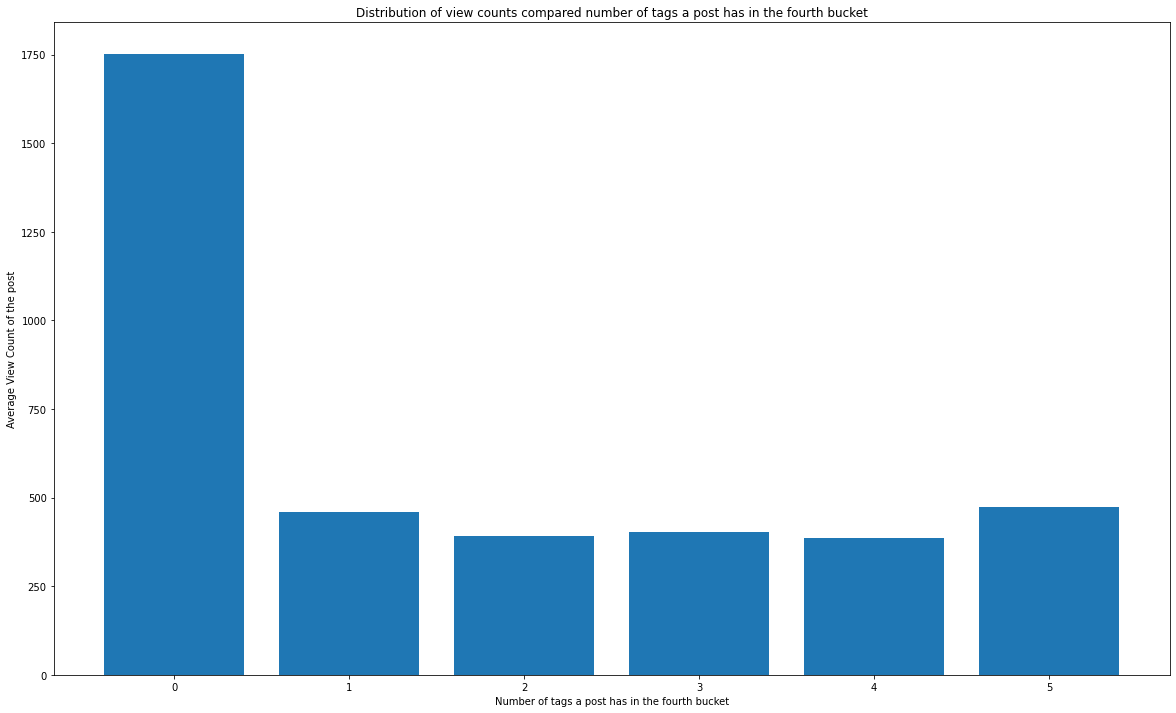

In [ ]:
plt.figure(1, [20,12])
plt.bar(tags4_dist_df["tags_4"], tags4_dist_df["avg_vc"])
plt.title("Distribution of view counts compared number of tags a post has in the fourth bucket")
plt.xlabel("Number of tags a post has in the fourth bucket")
plt.ylabel("Average View Count of the post")

In [ ]:
%%bigquery tags5_dist_df --project $project_id 

WITH
  tags_master AS (
  WITH
    t1 AS (
    SELECT
      tags_dist.id AS tag_id,
      post_tags.id AS post_id
    FROM (
      SELECT
        DISTINCT tag,
        AVG(view_count) AS avg_vc,
        ROW_NUMBER() OVER(ORDER BY AVG(view_count) DESC) AS id
      FROM (
        SELECT
          SPLIT(tags, "|") AS tags_array,
          view_count
        FROM
          `bigquery-public-data.stackoverflow.stackoverflow_posts`
        WHERE
          tags IS NOT NULL
          AND tags != ""
          AND view_count IS NOT NULL) posts_tags
      CROSS JOIN
        UNNEST(posts_tags.tags_array) AS tag
      GROUP BY
        tag
      ORDER BY
        avg_vc DESC ) tags_dist
    RIGHT OUTER JOIN (
      SELECT
        id,
        tag,
        view_count
      FROM (
        SELECT
          id,
          SPLIT(tags, "|") AS tags_array,
          view_count
        FROM
          `bigquery-public-data.stackoverflow.stackoverflow_posts`
        WHERE
          tags IS NOT NULL
          AND tags != ""
          AND view_count IS NOT NULL) posts_tags
      CROSS JOIN
        UNNEST(posts_tags.tags_array) AS tag
      ORDER BY
        id) post_tags
    ON
      tags_dist.tag = post_tags.tag)
  SELECT
    posts.view_count,
    (
    SELECT
      COUNT(*)
    FROM
      t1
    WHERE
      t1.post_id = posts.id
      AND t1.tag_id < 9085) AS tags_1,
    (
    SELECT
      COUNT(*)
    FROM
      t1
    WHERE
      t1.post_id = posts.id
      AND t1.tag_id < 2*9085
      AND t1.tag_id >= 9085) AS tags_2,
    (
    SELECT
      COUNT(*)
    FROM
      t1
    WHERE
      t1.post_id = posts.id
      AND t1.tag_id < 3*9085
      AND t1.tag_id >= 2*9085) AS tags_3,
    (
    SELECT
      COUNT(*)
    FROM
      t1
    WHERE
      t1.post_id = posts.id
      AND t1.tag_id < 4*9085
      AND t1.tag_id >= 3*9085) AS tags_4,
    (
    SELECT
      COUNT(*)
    FROM
      t1
    WHERE
      t1.post_id = posts.id
      AND t1.tag_id >= 4*9085) AS tags_5,
  FROM
    `bigquery-public-data.stackoverflow.stackoverflow_posts` posts
  WHERE
    title IS NOT NULL
    AND view_count IS NOT NULL)
SELECT
  tags_5,
  AVG(view_count) as avg_vc
FROM
  tags_master
GROUP BY
  tags_5

Query is running:   0%|          |

Downloading:   0%|          |

Text(0, 0.5, 'Average View Count of the post')

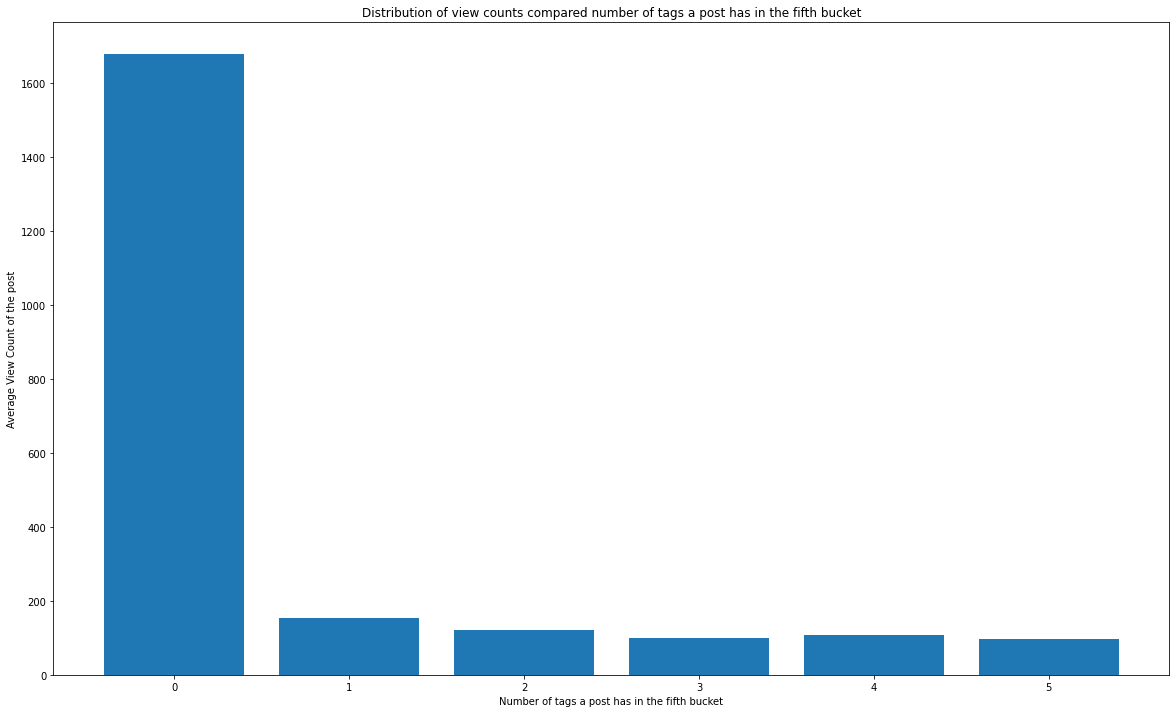

In [ ]:
plt.figure(1, [20,12])
plt.bar(tags5_dist_df["tags_5"], tags5_dist_df["avg_vc"])
plt.title("Distribution of view counts compared number of tags a post has in the fifth bucket")
plt.xlabel("Number of tags a post has in the fifth bucket")
plt.ylabel("Average View Count of the post")

---
Results:
As we can see in the second through the sixth visualizations, the posts that have more tags in the top bucket of tags have a greater average view count, while the posts that have more tags in the bottom buckets have lower average view counts. This intuitively makes sense because if a post has tags that are more popular, then that post itself would be more popular.

Using these visualizations, we've decided to add the number of tags a post has in each bucket as inputs for our model.

---

---
**Metric 4: Reputation of the user**

Here, we will analyze how the reputation score of the user who created a post on StackOverflow effects that post's visibility. To get the reputation of the user that posted, we join the tables `stackoverflow_posts` and `users` on the columns `owner_user_id` and `id` respectively. From here, we can group by the reputation of the users and get the average `view_counts` for the posts of users of each reputation.

---

In [ ]:
%%bigquery reputation_df --project $project_id 

SELECT
  user_data.reputation,
  AVG(view_count) AS vc
FROM (
  SELECT
    owner_user_id,
    view_count
  FROM
    `bigquery-public-data.stackoverflow.stackoverflow_posts`
  WHERE
    owner_user_id IS NOT NULL
    AND view_count IS NOT NULL) post_data
JOIN
  `bigquery-public-data.stackoverflow.users` user_data
ON
  post_data.owner_user_id = user_data.id
WHERE
  user_data.reputation IS NOT NULL
GROUP BY
  user_data.reputation
ORDER BY
  user_data.reputation

Query is running:   0%|          |

Downloading:   0%|          |

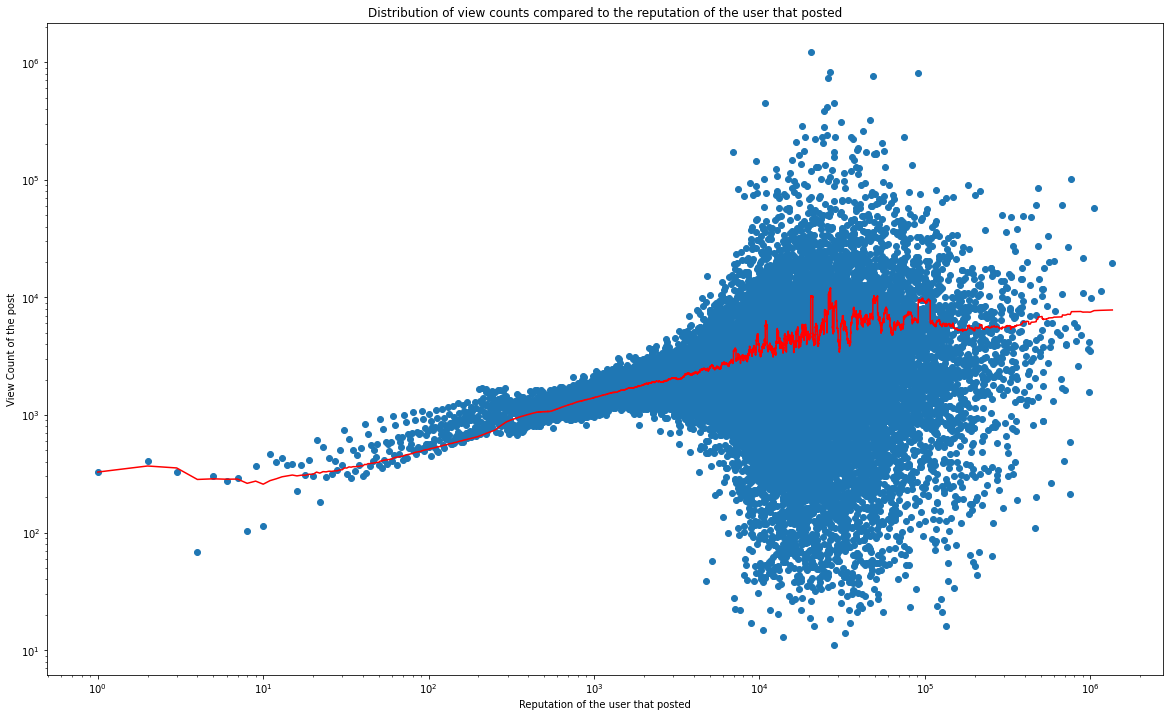

In [ ]:
plt.figure(1, [20,12])
plt.scatter(reputation_df["reputation"], reputation_df["vc"])
plt.title("Distribution of view counts compared to the reputation of the user that posted")
plt.xlabel("Reputation of the user that posted")
plt.ylabel("View Count of the post")
plt.xscale("log")
plt.yscale("log")

window = 250
x = np.array(list(reputation_df["reputation"].values))
y = np.array(list(reputation_df["vc"].values))
y_av = np.zeros(len(y))
for i in range(len(y)):
    y_av[i] = np.mean(y[max(0,i-window):i+1])
plt.plot(x, y_av, 'r')

---
Results:
Looking at the running average line (red), while there is a slight trend upward in view count as the reputation of the user that posted increases, the general plot shows that there isn't a significant correlation between the two metrics. Therefore, we are not going to include the reputation of the user that posted as an input for our model.

---

---
**Metric 5: Number of edits on a post**

Here, we will analyze how the number of edits on post on StackOverflow effects that post's visibility. To do so, we are going to count the number of edits on any given post by grouping on the `post_id` column in the `post_history` table Then, we are going to join the `post_history` and `stackoverflow_posts` tables on the columns `post_id` and `id` respectively, then grouping by the number of edits to get the average view counts of the posts for each number of edits.

---

In [ ]:
%%bigquery num_edits_df --project $project_id 

WITH
  final AS (
  WITH
    t1 AS (
    SELECT
      post_id,
      COUNT(*) AS num
    FROM
      `bigquery-public-data.stackoverflow.post_history`
    GROUP BY
      post_id
    ORDER BY
      post_id)
  SELECT
    *
  FROM
    t1
  JOIN (
    SELECT
      id,
      view_count
    FROM
      `bigquery-public-data.stackoverflow.stackoverflow_posts`) AS t2
  ON
    t1.post_id = t2.id)
SELECT
  num,
  AVG(view_count) AS average
FROM
  final
WHERE
  view_count IS NOT NULL
GROUP BY
  num
ORDER BY
  num DESC

Query is running:   0%|          |

Downloading:   0%|          |

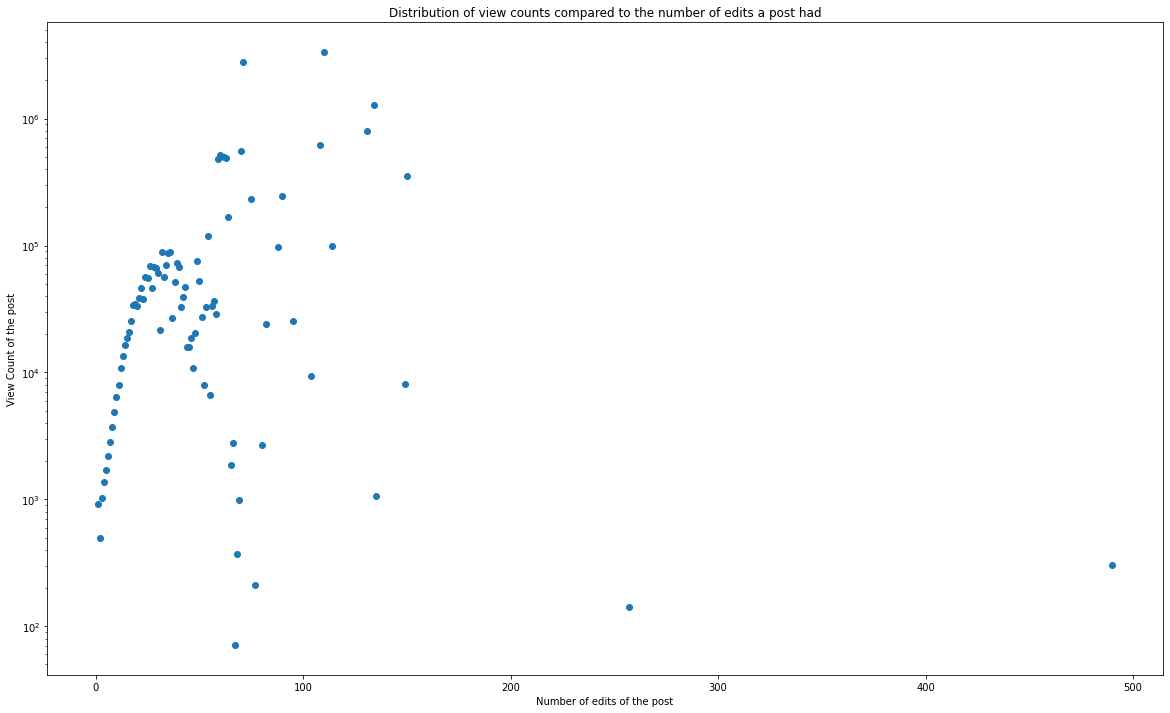

In [ ]:
plt.figure(1, [20,12])
plt.scatter(num_edits_df["num"], num_edits_df["average"])
plt.title("Distribution of view counts compared to the number of edits a post had")
plt.xlabel("Number of edits of the post")
plt.ylabel("View Count of the post")
plt.yscale("log")

---
Results:
Looking at the graph, we see a strong correlation between the number of edits a post has and the view counts, with the correlation being positive up until around 40 edits, where there is a general trend downward. Given that there is a general trend in the number of edits that a post has and the average view counts, we are going to put the number of edits as an input in our model.

---

---
**Metric 6: Age of the User vs Age of the Post**

Here, we will analyze how the difference in time bewtween when a user creates a post and when that user created their account effects that post's visibility. To do so, we re going to join the tables `stackoverflow_posts` and `users` on the columns `owner_user_id` and `id` respectively. From there, we are going to calculate the difference in the dates between when the account was created and when the post was created, essentially getting the age of the account at the time the post was created. From there, we are grouping by this age to get the average view count for the age of the post with respect to the age of the account.

---

In [ ]:
%%bigquery new_user_df --project $project_id 

SELECT
  ABS(DATE_DIFF(user_date, post_date, DAY)) AS diff,
  AVG(view_count) AS vc
FROM (
  SELECT
    view_count,
    creation_date AS post_date,
    user_date
  FROM
    `bigquery-public-data.stackoverflow.stackoverflow_posts`
  JOIN (
    SELECT
      id,
      creation_date AS user_date
    FROM
      `bigquery-public-data.stackoverflow.users`) AS t2
  ON
    owner_user_id = t2.id)
GROUP BY
  diff
ORDER BY
  diff

Query is running:   0%|          |

Downloading:   0%|          |

Text(0, 0.5, 'View Count of the post')

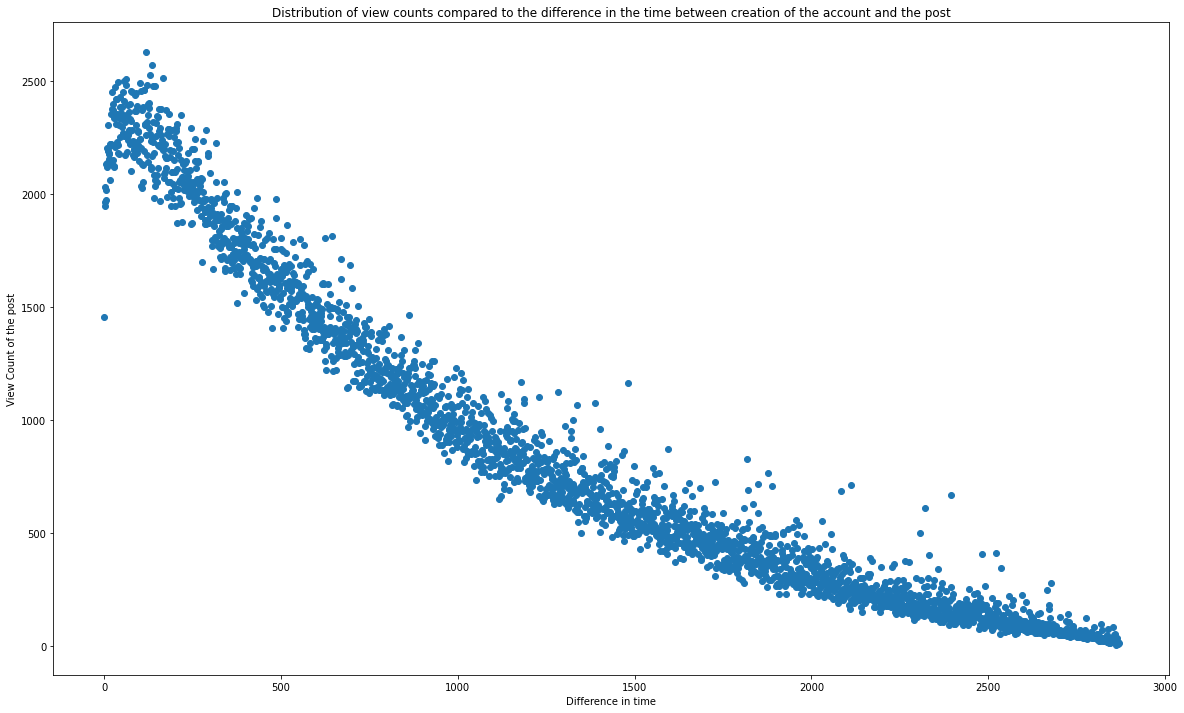

In [ ]:
plt.figure(1, [20,12])
plt.scatter(new_user_df["diff"], new_user_df["vc"])
plt.title("Distribution of view counts compared to the difference in the time between creation of the account and the post")
plt.xlabel("Difference in time")
plt.ylabel("View Count of the post")

---
Results:
Here we see a very clear negative correlation between the difference in the ages of the post and the user that posted, and the view count for those posts. This is the strongest correlation we've seen among any of the metrics we've measured. This intuitively makes sense because the longer a post has been up in relation to the creation of the account, the less likely it is to be seen beecause users who create accounts just to post a question are more likely to more urgently want a response, and thus will add incentives for people to view and answer that questions (ie add a bounty on the post which increases the user who answer's reputation score). However, people who are more casually using the website and are generally just posting after having been on the site for a long time are less likely to incentivize people to answer their posts.

Because we can see a strong negative correlation between these two metrics, we are going to include the difference in age between the post and the account an input in our model.

---

---
**Most Significicant Metrics:**

After analyzing 6 metrics on the posts, only 4 metrics showed correlation with the view count:
*   The length of the title on a post
*   The tags the user put on the post
*   The number of edits on a post
*   The difference in time between when a post was made and when the account who posted it was made

Using these four inputs, we are going to train a model to predict if a post will have a view count above or below the median view count of all posts.

---

---
**Analysis of Metrics on the Answers on StackOverflow Posts**

Here, we are going to explore five metrics to see if they have any effect on the ratio between the scores of the accepted answer of a post and the other other answers on the question that were not chosen as the accepted answer. In doing so, we hope to find metrics that we can use to predict whether or not a given answer is going to be accepted or not.

---

---
**Correlation between the percentage of the total score an answer has and the likelihood that it will be selected as the accepted answer**

To find a metric we can use to predict the likelihood that an answer will be accepted or not, we have decided to use the percentage of the total score on all answers on a post as our measure for credibility.

For example, if there are two answers on a post, one with a score of 15 and one with a score of 5, the percentage for the first answer would be 75% while the percentage for the second would be 25%. Because the first answer has a higher percentage of the total score on that post, we would deem it more credibile. To check if this is a good metric we should use to predict if an answer would be accepted, we created the chart below that gets the percentage for all accepted answers and the percentage for all not accepted answers. As seen in the visualization, answers that are marked as accepted have a much higher percentage of the total score across all answers on their respective posts. Therefore, we can continue and use this metric as a good measure for if an answer would be accepted or not. 

---

In [ ]:
%%bigquery acc_rej_df --project $project_id 

SELECT
  accepted,
  AVG(frac) AS frac
FROM (
  SELECT
    (CASE posts.accepted_answer_id
        WHEN answers.id THEN 1
      ELSE
      0
    END
      ) AS accepted,
    SAFE_DIVIDE(score, (
      SELECT
        SUM(score)
      FROM
        `bigquery-public-data.stackoverflow.posts_answers` a1
      WHERE
        a1.parent_id = answers.parent_id)) AS frac
  FROM
    `bigquery-public-data.stackoverflow.posts_answers` answers
  JOIN (
    SELECT
      id,
      accepted_answer_id
    FROM
      `bigquery-public-data.stackoverflow.stackoverflow_posts`
    WHERE
      accepted_answer_id IS NOT NULL) posts
  ON
    posts.id = answers.parent_id)
GROUP BY
  accepted

Query is running:   0%|          |

Downloading:   0%|          |

Text(0.5, 1.0, 'Accepted vs Rejected')

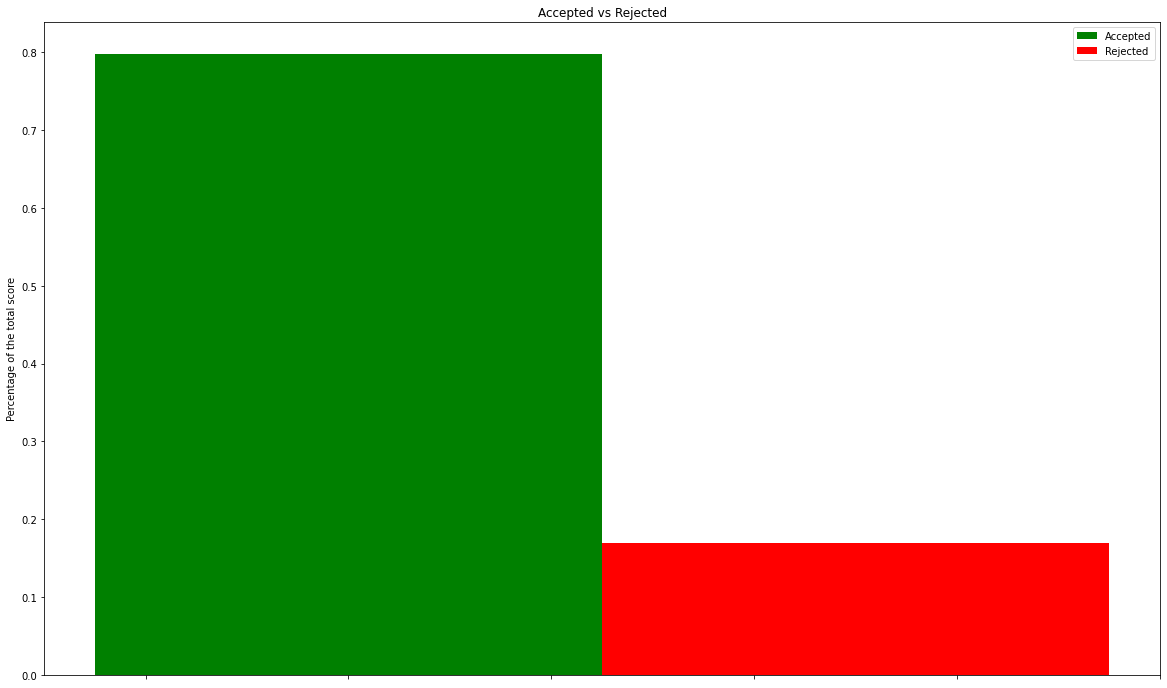

In [ ]:
plt.figure(1, [20,12])
plt.bar(x=1, height=acc_rej_df['frac'][1], color='g', width=0.25, label='Accepted')
plt.bar(x=1+0.25, height=acc_rej_df['frac'][0], color='r', width=0.25, label='Rejected')
plt.gca().axes.xaxis.set_ticklabels([])
plt.legend()
plt.ylabel("Percentage of the total score")

plt.title('Accepted vs Rejected')

---
**Metric 1: How long after the post was made was the answer posted**

Here, we will analyze how the difference in time bewtween when a post was created and when it was answered effects that answer's credibility, which will be measured using the `score` column of the answers table. Here, we first join the tables `posts_answers` and `stackoverflow_posts` on the columns `parent_id` and `id` respectively. From there, we are tracking two metrics, the difference in time between the post being made and the answer being posted, and the percentage of the total score that all answers on a post have come from that answer. We then group by the time differences so that we can get the averages of those percentages and order by the time difference so that we can draw a line of the running average so that we can see the general trend.

---

In [ ]:
%%bigquery answer_time_df --project $project_id 

SELECT
  ABS(DATE_DIFF(answers.creation_date, posts.creation_date, DAY)) AS time_diff,
  AVG(SAFE_DIVIDE(answers.score, (
      SELECT
        SUM(answers.score)
      FROM
        `bigquery-public-data.stackoverflow.posts_answers` a1
      WHERE
        a1.parent_id = answers.parent_id))) AS avg_score
FROM
  `bigquery-public-data.stackoverflow.posts_answers` answers
JOIN
  `bigquery-public-data.stackoverflow.stackoverflow_posts` posts
ON
  answers.parent_id = posts.id
WHERE
  answers.score IS NOT NULL
GROUP BY
  time_diff
ORDER BY
  time_diff

Query is running:   0%|          |

Downloading:   0%|          |

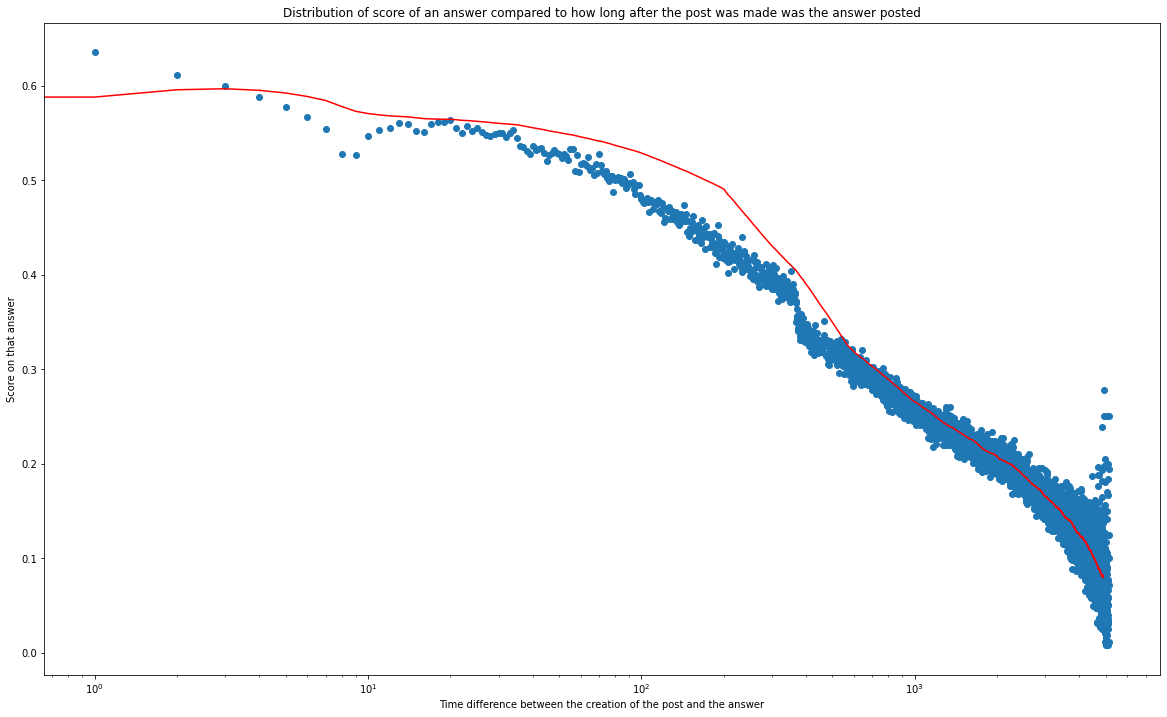

In [ ]:
plt.figure(1, [20,12])
plt.plot(list(answer_time_df["time_diff"].values), list(answer_time_df["avg_score"].values), 'o')
plt.title("Distribution of score of an answer compared to how long after the post was made was the answer posted")
plt.xlabel("Time difference between the creation of the post and the answer")
plt.ylabel("Score on that answer")
plt.xscale("log")



window = 200
x = np.array(list(answer_time_df["time_diff"].values))
y = np.array(list(answer_time_df["avg_score"].values))
y_av = np.zeros(len(y))
for i in range(len(y)):
    y_av[i] = np.mean(y[max(0,i-window):i+1])
plt.plot(x, y_av, 'r')

---
Results:
As shown by the visualization, we see that as the time difference between the creation of the post and answer being posted increases, the overall percentage of the total score of all answers on that posts decreases. This makes sense intutively because the earlier a post is made, the more likely that people are to upvote it as it is the only answer. We initially thought that as more time passes, more and more answers are posted for the same question, so the percentage that the answer would have of the total would decrease, but this is not an issue because we are calculating the percentages after all answers have been posted. 

Because there is a clear negative correlation between the time difference and the proportion of the total score on all answers on a post that any given answer has, we are going to use this metric as in input for our model.

---

---
**Metric 2: Length of the Answer**

Here, we will analyze how the length of an answer effects that answer's credibility, which we will continue to measure using the percentage of the total score of all the answers on a post that any given answer has. We are using the `post_answers` table and using two key columsn, the `body` of the answer and the `score` that an answer has. We get the length of any given answer, group by that length, and then average the percentages. 

---

In [ ]:
%%bigquery answer_len_df --project $project_id 


SELECT
  LENGTH(answers.body) AS answer_length,
  AVG(SAFE_DIVIDE(answers.score, (
      SELECT
        SUM(answers.score)
      FROM
        `bigquery-public-data.stackoverflow.posts_answers` a1
      WHERE
        a1.parent_id = answers.parent_id))) AS avg_score
FROM
  `bigquery-public-data.stackoverflow.posts_answers` answers
WHERE
  answers.score IS NOT NULL
GROUP BY
  answer_length
ORDER BY
  answer_length

Query is running:   0%|          |

Downloading:   0%|          |

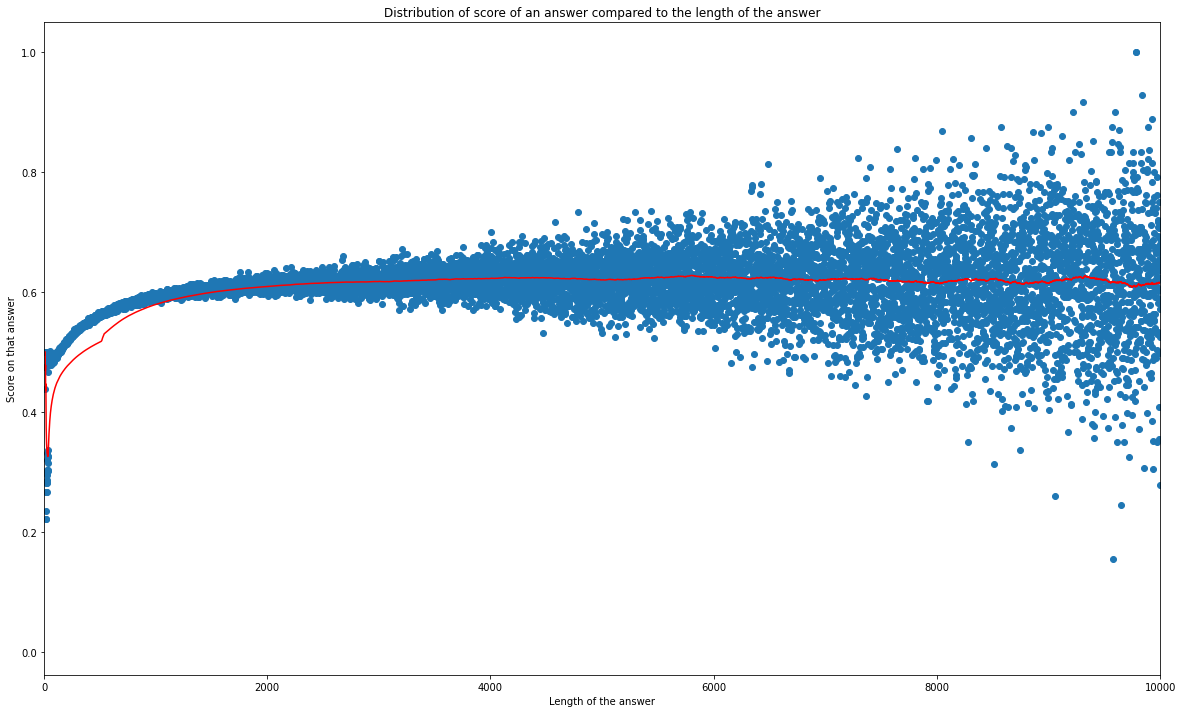

In [ ]:
plt.figure(1, [20,12])
plt.plot(list(answer_len_df["answer_length"].values), list(answer_len_df["avg_score"].values), 'o')
plt.title("Distribution of score of an answer compared to the length of the answer")
plt.xlabel("Length of the answer")
plt.ylabel("Score on that answer")
#plt.xscale("log")
plt.xlim([0, 10000])

window = 500
x = np.array(list(answer_len_df["answer_length"].values))
y = np.array(list(answer_len_df["avg_score"].values))
y_av = np.zeros(len(y))
for i in range(len(y)):
    y_av[i] = np.mean(y[max(0,i-window):i+1])
plt.plot(x, y_av, 'r')

---
Results:

Here, we don't see any correlation between the length of an answer and percentage of the total score that answer has. This intuitvely makes sense because a longer answer does not change the content of the answer itself. An answer could be really long and make absolutely no sense so it would have a really low score compared to the other answers on a question.

Because we see no correlation between the two metrics, we are not going to include the length of the answer as an input for our model.

---

---
**Metric 3: Badges**

Here, we are measuring the effects of a user's badges on the credibility of their answers. To do so, we are assigning every user a score based on the number of badges they have and the class of their badges (+1 for a bronze badge, +2 for a silver badge, and +3 for a gold badge). We are joining the tables `badges` and `posts_answers` on the columns `user_id` and `owner_user_id` respectively. From here, for every answer, we can use the badges table to calulate the user's `score` and get the percentage of the total score that the answer makes up. Then, we group by `user_score` to get the average percentage for every user score.

---

In [ ]:
%%bigquery userScore_answerScore_df --project $project_id 

WITH
  t1 AS (
  SELECT
    user_id,
    SUM(CASE class
        WHEN 1 THEN 1
      ELSE
      0
    END
      ) AS gold,
    SUM(CASE class
        WHEN 2 THEN 1
      ELSE
      0
    END
      ) AS silver,
    SUM(CASE class
        WHEN 3 THEN 1
      ELSE
      0
    END
      ) AS bronze,
  FROM
    `bigquery-public-data.stackoverflow.badges`
  GROUP BY
    user_id)
SELECT
  gold * 3 + silver * 2 + bronze * 1 AS user_score,
  AVG(SAFE_DIVIDE(score, (
      SELECT
        SUM(score)
      FROM
        `bigquery-public-data.stackoverflow.posts_answers` a1
      WHERE
        a1.parent_id = answers.parent_id))) AS avg_score
FROM
  `bigquery-public-data.stackoverflow.posts_answers` answers
JOIN
  t1
ON
  t1.user_id = answers.owner_user_id
GROUP BY
  user_score
ORDER BY
  user_score

Query is running:   0%|          |

Downloading:   0%|          |

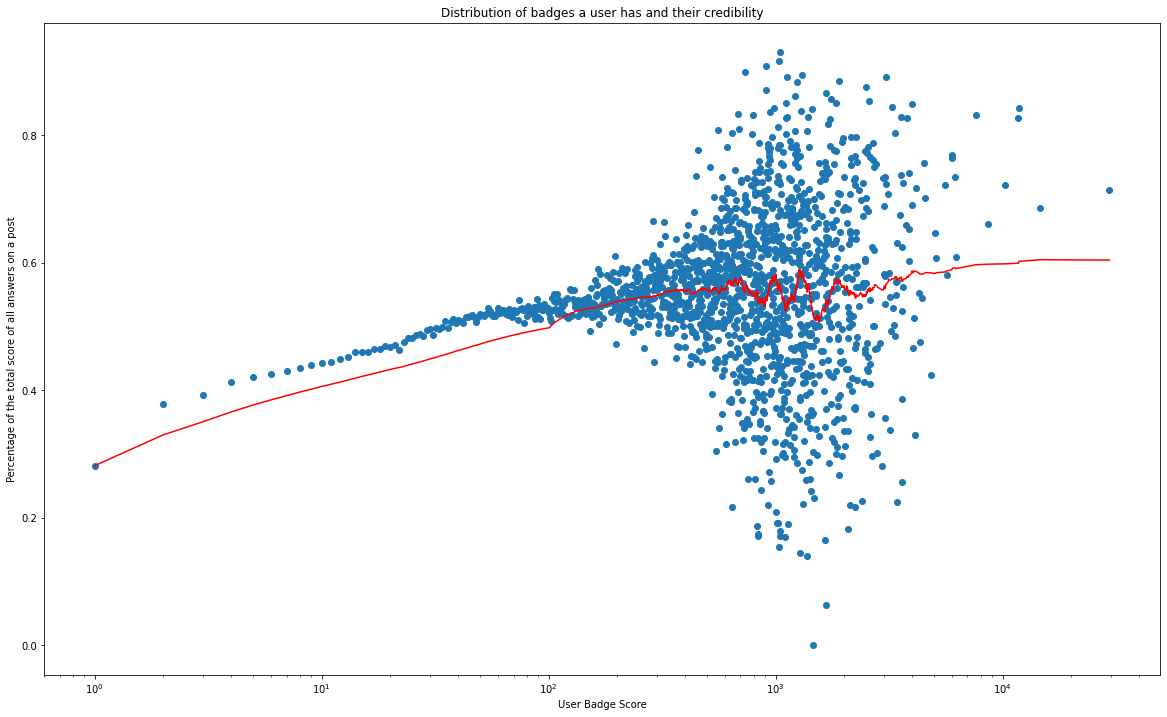

In [ ]:
plt.figure(1, [20,12])
plt.plot(list(userScore_answerScore_df["user_score"].values), list(userScore_answerScore_df["avg_score"].values), 'o')
plt.title("Distribution of badges a user has and their credibility")
plt.xlabel("User Badge Score")
plt.ylabel("Percentage of the total score of all answers on a post")
plt.xscale("log")

window = 100
x = np.array(list(userScore_answerScore_df["user_score"].values))
y = np.array(list(userScore_answerScore_df["avg_score"].values))
y_av = np.zeros(len(y))
for i in range(len(y)):
    y_av[i] = np.mean(y[max(0,i-window):i+1])
plt.plot(x, y_av, 'r')

---
Results:

From this visualization, we see that the running average trend line increases as the user's badge score increases. This intutively makes sense because users that have more and higher class badges are more likely to have better answers on posts and therefore have a higher credibility to other users.

Because we see a large difference as the user's badge score increases (going from around ~0.3 to ~0.6) and the general trend upward, we are going to include a user's badge score as an input for our model.

---

---
**Metric 4: Reputation of the user**

Here, we will analyze how the reputation of the user that answered a post on StackOverflow effects that user's credibility. To do so, we are going to join the tables `posts_answers` and `users` on the columns `owner_user_id` and `id` respectively. From there, we are going to calculate the percentage for each post and get the reputation of the user from the `users` table.

---

In [ ]:
%%bigquery answer_reputation_df --project $project_id 

SELECT
  users.reputation,
  AVG(SAFE_DIVIDE(answers.score, (
      SELECT
        SUM(answers.score)
      FROM
        `bigquery-public-data.stackoverflow.posts_answers` a1
      WHERE
        a1.parent_id = answers.parent_id))) AS avg_score
FROM
  `bigquery-public-data.stackoverflow.posts_answers` answers
JOIN
  `bigquery-public-data.stackoverflow.users` users
ON
  users.id = answers.owner_user_id
WHERE
  answers.score IS NOT NULL
GROUP BY
  users.reputation
ORDER BY
  users.reputation

Query is running:   0%|          |

Downloading:   0%|          |

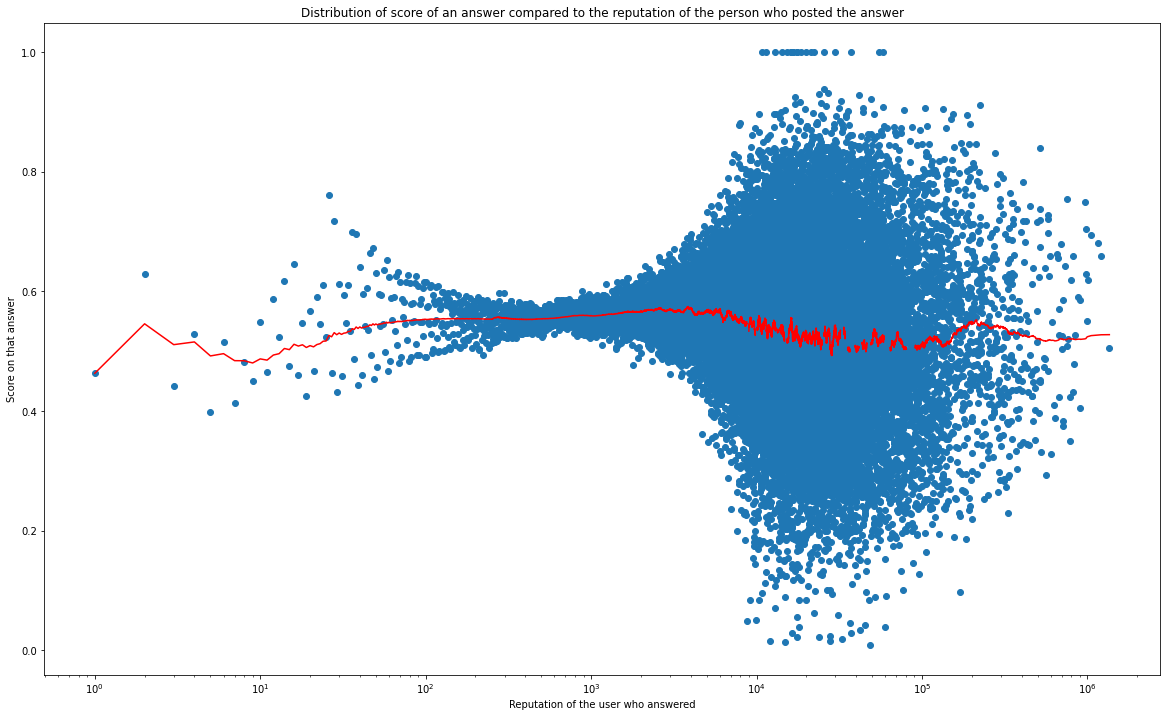

In [ ]:
plt.figure(1, [20,12])
plt.plot(list(answer_reputation_df["reputation"].values), list(answer_reputation_df["avg_score"].values), 'o')
plt.title("Distribution of score of an answer compared to the reputation of the person who posted the answer")
plt.xlabel("Reputation of the user who answered")
plt.ylabel("Score on that answer")
plt.xscale("log")

window = 250
x = np.array(list(answer_reputation_df["reputation"].values))
y = np.array(list(answer_reputation_df["avg_score"].values))
y_av = np.zeros(len(y))
for i in range(len(y)):
    y_av[i] = np.mean(y[max(0,i-window):i+1])
plt.plot(x, y_av, 'r')

---
Results:

Here, we see that there is no trend in the running average line, indicating that there is no correlation between the two metrics. This result was very surprising to us because we had assumed that users with higher reputations would have higher scores and therefore would have a higher percentage.

Despite what we had instinctively thought, because the data implies that there is no correlation, we are not going to have the user's reputation be an input in the model.

---

---
**Metric 5: Reach of the user**

Here, we will analyze how the reach of the user, the number of times a person has viewed a post or answer made by that user, that answered a post on StackOverflow effects that post's credibility. To do so, we are going to first oin the tables `posts_answers` and `users` on the columns `owner_user_id` and `id` respectively. From there, we are going to calculate the percentage for each post and get the reach (`views`) of the user from the `users` table.

---

In [ ]:
%%bigquery answer_reach_df --project $project_id 

SELECT
  users.views,
  AVG(SAFE_DIVIDE(answers.score, (
      SELECT
        SUM(answers.score)
      FROM
        `bigquery-public-data.stackoverflow.posts_answers` a1
      WHERE
        a1.parent_id = answers.parent_id))) AS avg_score
FROM
  `bigquery-public-data.stackoverflow.posts_answers` answers
JOIN
  `bigquery-public-data.stackoverflow.users` users
ON
  users.id = answers.owner_user_id
WHERE
  answers.score IS NOT NULL
GROUP BY
  users.views
ORDER BY
  users.views

Query is running:   0%|          |

Downloading:   0%|          |

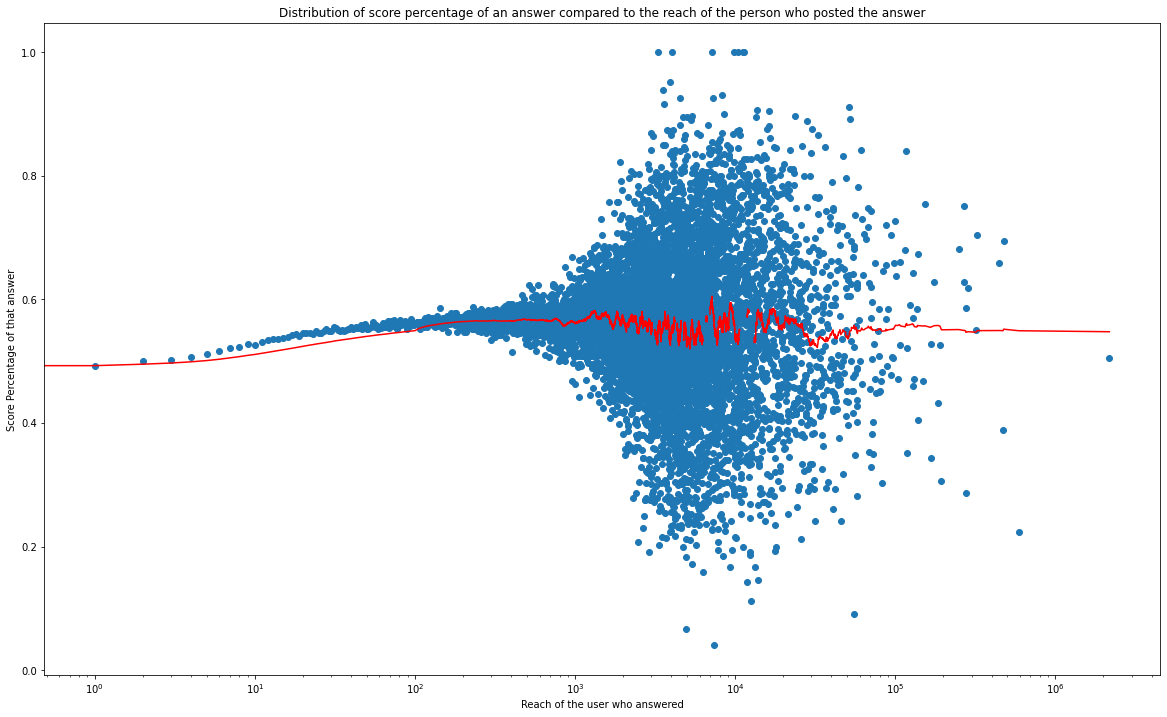

In [ ]:
plt.figure(1, [20,12])
plt.plot(list(answer_reach_df["views"].values), list(answer_reach_df["avg_score"].values), 'o')
plt.title("Distribution of score percentage of an answer compared to the reach of the person who posted the answer")
plt.xlabel("Reach of the user who answered")
plt.ylabel("Score Percentage of that answer")
plt.xscale("log")

window = 100
x = np.array(list(answer_reach_df["views"].values))
y = np.array(list(answer_reach_df["avg_score"].values))
y_av = np.zeros(len(y))
for i in range(len(y)):
    y_av[i] = np.mean(y[max(0,i-window):i+1])
plt.plot(x, y_av, 'r')

---
Results:

Similar to what we saw with user reputation, we saw no correlation between the two metrics despite predicting that there would be some correlation instinctively. Here, we had assumed that with more posts and answers someone makes on the platform, that they would be seen as a more credibile user and have a higher answer score percentage.

Despite what we had instinctively thought, because the data implies that there is no correlation, we are not going to have the user's reach be an input in the model.

---

---
**Most Significicant Metrics:**

After analyzing 5 metrics on the answers to the posts, only two metrics showed correlation with the percentage of the answer score:
*   The time difference between when the post was created and when the answer was posted
*   The badges of the user who answered

Using these two inputs, we are going to train a model to predict if an answer is going to be selected as the accepted answer or not.

---

## Data Prediction

---
**Posts Model**

So after we created the dataset, we're going to create model which would be trained to classify whether the view counts on a post is higher than the mean of all the view counts on all the posts or not. The median of the view counts is 1655, so if the view count on a post is higher than 1655 that counts as a 1 and if it's lower that counts as a 0.


First we are going to split the dataset into 80-10-10 training-validation-testing sets respectively. We do so by using a hashing function so each row stays assigned to the same set regardless of how many times the code will run, as opposed to rand() function that can change with every run.

---

In [ ]:
model_dataset_name = 'bqml_stackoverflow'

dataset = bigquery.Dataset(client.dataset(model_dataset_name))
dataset.location = 'US'
client.create_dataset(dataset)

Conflict: ignored

So after we created the dataset, we're going to create model which would be trained to classify whether the view counts on a post is higher than the mean of all the view counts on all the posts or not. The median of the view counts is 1655, so if the view count on a post is higher than 1655 that counts as a 1 and if it's lower that counts as a 0.


First we are going to split the dataset into 80-10-10 training-validation-testing sets respectively. We do so by using a hashing function so each row stays assigned to the same set regardless of how many times the code will run, as opposed to rand() function that can change with every run.

In [ ]:
%%bigquery ml_df --project $project_id 

CREATE OR REPLACE MODEL
  `bqml_stackoverflow.postsModel1` OPTIONS(model_type='logistic_reg') AS
SELECT
IF
  (view_count < 1655, 0, 1) AS label,
  title_length AS feature1,
  tags_1 AS feature2,
  tags_2 AS feature3,
  tags_3 AS feature4,
  tags_4 AS feature5,
  tags_5 AS feature6,
  num_edits AS feature7,
  time_diff AS feature8
FROM (
  SELECT
    *,
    CASE
      WHEN ABS(MOD(FARM_FINGERPRINT(CAST(id AS STRING)), 10)) < 8 THEN 'train'
      WHEN ABS(MOD(FARM_FINGERPRINT(CAST(id AS STRING)), 10)) = 8 THEN 'validation'
      WHEN ABS(MOD(FARM_FINGERPRINT(CAST(id AS STRING)), 10)) = 9 THEN 'test'
  END
    AS split_set
  FROM (
    WITH
      t1 AS (
      SELECT
        tags_dist.id AS tag_id,
        post_tags.id AS post_id
      FROM (
        SELECT
          DISTINCT tag,
          AVG(view_count) AS avg_vc,
          ROW_NUMBER() OVER(ORDER BY AVG(view_count) DESC) AS id
        FROM (
          SELECT
            SPLIT(tags, "|") AS tags_array,
            view_count
          FROM
            `bigquery-public-data.stackoverflow.stackoverflow_posts`
          WHERE
            tags IS NOT NULL
            AND tags != ""
            AND view_count IS NOT NULL) posts_tags
        CROSS JOIN
          UNNEST(posts_tags.tags_array) AS tag
        GROUP BY
          tag
        ORDER BY
          avg_vc DESC ) tags_dist
      RIGHT OUTER JOIN (
        SELECT
          id,
          tag,
          view_count
        FROM (
          SELECT
            id,
            SPLIT(tags, "|") AS tags_array,
            view_count
          FROM
            `bigquery-public-data.stackoverflow.stackoverflow_posts`
          WHERE
            tags IS NOT NULL
            AND tags != ""
            AND view_count IS NOT NULL) posts_tags
        CROSS JOIN
          UNNEST(posts_tags.tags_array) AS tag
        ORDER BY
          id) post_tags
      ON
        tags_dist.tag = post_tags.tag)
    SELECT
      posts.id,
      LENGTH(title) AS title_length,
      posts.view_count,
      (
      SELECT
        COUNT(*)
      FROM
        t1
      WHERE
        t1.post_id = posts.id
        AND t1.tag_id < 9085) AS tags_1,
      (
      SELECT
        COUNT(*)
      FROM
        t1
      WHERE
        t1.post_id = posts.id
        AND t1.tag_id < 2*9085
        AND t1.tag_id >= 9085) AS tags_2,
      (
      SELECT
        COUNT(*)
      FROM
        t1
      WHERE
        t1.post_id = posts.id
        AND t1.tag_id < 3*9085
        AND t1.tag_id >= 2*9085) AS tags_3,
      (
      SELECT
        COUNT(*)
      FROM
        t1
      WHERE
        t1.post_id = posts.id
        AND t1.tag_id < 4*9085
        AND t1.tag_id >= 3*9085) AS tags_4,
      (
      SELECT
        COUNT(*)
      FROM
        t1
      WHERE
        t1.post_id = posts.id
        AND t1.tag_id >= 4*9085) AS tags_5,
      (
      SELECT
        COUNT(*)
      FROM
        `bigquery-public-data.stackoverflow.post_history` hist
      WHERE
        hist.post_id = posts.id) AS num_edits,
      (
      SELECT
        ABS(DATE_DIFF(users.creation_date, posts.creation_date, DAY))
      FROM
        `bigquery-public-data.stackoverflow.users` users
      WHERE
        posts.owner_user_id = users.id) AS time_diff
    FROM
      `bigquery-public-data.stackoverflow.stackoverflow_posts` posts
    WHERE
      title IS NOT NULL
      AND view_count IS NOT NULL))
WHERE
  split_set = 'train'

Query is running:   0%|          |

In [ ]:
%%bigquery --project $project_id

# Run cell to view training stats

SELECT
  *
FROM
  ML.TRAINING_INFO(MODEL `bqml_stackoverflow.postsModel1`)

Query is running:   0%|          |

Downloading:   0%|          |

,training_run,iteration,loss,eval_loss,learning_rate,duration_ms
0,0,6,0.406478,0.411623,12.8,20344
1,0,5,0.407828,0.413475,6.4,19706
2,0,4,0.423998,0.428169,3.2,18857
3,0,3,0.479398,0.481583,1.6,18475
4,0,2,0.557828,0.558769,0.8,17909
5,0,1,0.624709,0.625070,0.4,23218
6,0,0,0.668306,0.668416,0.2,14910


Now we will evaluate on the validation set to see how our model did.

In [ ]:
%%bigquery --project $project_id

SELECT
  *
FROM
  ML.EVALUATE(MODEL `bqml_stackoverflow.postsModel1`,
    (
    SELECT
 IF(view_count < 1655, 0, 1) AS label,
  title_length AS feature1, tags_1 AS feature2, tags_2 AS feature3, tags_3 AS feature4, tags_4 AS feature5, tags_5 AS feature6, num_edits AS feature7, time_diff AS feature8

FROM (
  SELECT
    *,
       CASE
    WHEN ABS(MOD(FARM_FINGERPRINT(CAST(id AS STRING)), 10)) < 8 THEN 'train'
    WHEN ABS(MOD(FARM_FINGERPRINT(CAST(id AS STRING)), 10)) = 8 THEN 'validation'
    WHEN ABS(MOD(FARM_FINGERPRINT(CAST(id AS STRING)), 10)) = 9 THEN 'test'
END AS split_set
  FROM (
    WITH
      t1 AS (
      SELECT
        tags_dist.id AS tag_id,
        post_tags.id AS post_id
      FROM (
        SELECT
          DISTINCT tag,
          AVG(view_count) AS avg_vc,
          ROW_NUMBER() OVER(ORDER BY AVG(view_count) DESC) AS id
        FROM (
          SELECT
            SPLIT(tags, "|") AS tags_array,
            view_count
          FROM
            `bigquery-public-data.stackoverflow.stackoverflow_posts`
          WHERE
            tags IS NOT NULL
            AND tags != ""
            AND view_count IS NOT NULL) posts_tags
        CROSS JOIN
          UNNEST(posts_tags.tags_array) AS tag
        GROUP BY
          tag
        ORDER BY
          avg_vc DESC ) tags_dist
      RIGHT OUTER JOIN (
        SELECT
          id,
          tag,
          view_count
        FROM (
          SELECT
            id,
            SPLIT(tags, "|") AS tags_array,
            view_count
          FROM
            `bigquery-public-data.stackoverflow.stackoverflow_posts`
          WHERE
            tags IS NOT NULL
            AND tags != ""
            AND view_count IS NOT NULL) posts_tags
        CROSS JOIN
          UNNEST(posts_tags.tags_array) AS tag
        ORDER BY
          id) post_tags
      ON
        tags_dist.tag = post_tags.tag)
    SELECT
      posts.id,
      LENGTH(title) AS title_length,
      posts.view_count,
      (
      SELECT
        COUNT(*)
      FROM
        t1
      WHERE
        t1.post_id = posts.id
        AND t1.tag_id < 9085) AS tags_1,
      (
      SELECT
        COUNT(*)
      FROM
        t1
      WHERE
        t1.post_id = posts.id
        AND t1.tag_id < 2*9085
        AND t1.tag_id >= 9085) AS tags_2,
      (
      SELECT
        COUNT(*)
      FROM
        t1
      WHERE
        t1.post_id = posts.id
        AND t1.tag_id < 3*9085
        AND t1.tag_id >= 2*9085) AS tags_3,
      (
      SELECT
        COUNT(*)
      FROM
        t1
      WHERE
        t1.post_id = posts.id
        AND t1.tag_id < 4*9085
        AND t1.tag_id >= 3*9085) AS tags_4,
      (
      SELECT
        COUNT(*)
      FROM
        t1
      WHERE
        t1.post_id = posts.id
        AND t1.tag_id >= 4*9085) AS tags_5,
      (
      SELECT
        COUNT(*)
      FROM
        `bigquery-public-data.stackoverflow.post_history` hist
      WHERE
        hist.post_id = posts.id) AS num_edits,
      (
      SELECT
        ABS(DATE_DIFF(users.creation_date, posts.creation_date, DAY))
      FROM
        `bigquery-public-data.stackoverflow.users` users
      WHERE
        posts.owner_user_id = users.id) AS time_diff
    FROM
      `bigquery-public-data.stackoverflow.stackoverflow_posts` posts
    WHERE
      title IS NOT NULL
      AND view_count IS NOT NULL))
WHERE
  split_set = 'validation'))

Query is running:   0%|          |

Downloading:   0%|          |

,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,0.524728,0.010402,0.847815,0.0204,0.406938,0.653486


We got a really good accuracy but the f1_score and recall would tell us otherwise. These low recall values tell us that there are lots of false negatives. After scrutinizing the dataset we see that the number of view counts less than the mean is significantly more than the number of view counts bigger than the mean. In fact, percisely 84.777859589% of the view counts are less than the mean, which is exactly the accuracy that we're getting. Thus, the only explaination is that the model is only outputting zeros and ignoring the posts with higher view counts than the mean. Thus we're going to use the median as a threshold instead of the mean. So when a post's view count is bigger than the median then the model outputs 1 and when it's less it outputs 0. The median is percisely 220, so we're going to create model2 that compares the view counts of a post to 220. 

In [ ]:
%%bigquery ml_df --project $project_id 

CREATE OR REPLACE MODEL `bqml_stackoverflow.postsModel2`
OPTIONS(model_type='logistic_reg') AS
SELECT
  IF(view_count < 220, 0, 1) AS label,
  title_length AS feature1, tags_1 AS feature2, tags_2 AS feature3, tags_3 AS feature4, tags_4 AS feature5, tags_5 AS feature6, num_edits AS feature7, time_diff AS feature8
FROM (
  SELECT
    *,
    CASE
    WHEN ABS(MOD(FARM_FINGERPRINT(CAST(id AS STRING)), 10)) < 8 THEN 'train'
    WHEN ABS(MOD(FARM_FINGERPRINT(CAST(id AS STRING)), 10)) = 8 THEN 'validation'
    WHEN ABS(MOD(FARM_FINGERPRINT(CAST(id AS STRING)), 10)) = 9 THEN 'test'
END AS split_set
  FROM (
    WITH
      t1 AS (
      SELECT
        tags_dist.id AS tag_id,
        post_tags.id AS post_id
      FROM (
        SELECT
          DISTINCT tag,
          AVG(view_count) AS avg_vc,
          ROW_NUMBER() OVER(ORDER BY AVG(view_count) DESC) AS id
        FROM (
          SELECT
            SPLIT(tags, "|") AS tags_array,
            view_count
          FROM
            `bigquery-public-data.stackoverflow.stackoverflow_posts`
          WHERE
            tags IS NOT NULL
            AND tags != ""
            AND view_count IS NOT NULL) posts_tags
        CROSS JOIN
          UNNEST(posts_tags.tags_array) AS tag
        GROUP BY
          tag
        ORDER BY
          avg_vc DESC ) tags_dist
      RIGHT OUTER JOIN (
        SELECT
          id,
          tag,
          view_count
        FROM (
          SELECT
            id,
            SPLIT(tags, "|") AS tags_array,
            view_count
          FROM
            `bigquery-public-data.stackoverflow.stackoverflow_posts`
          WHERE
            tags IS NOT NULL
            AND tags != ""
            AND view_count IS NOT NULL) posts_tags
        CROSS JOIN
          UNNEST(posts_tags.tags_array) AS tag
        ORDER BY
          id) post_tags
      ON
        tags_dist.tag = post_tags.tag)
    SELECT
      posts.id,
      LENGTH(title) AS title_length,
      posts.view_count,
      (
      SELECT
        COUNT(*)
      FROM
        t1
      WHERE
        t1.post_id = posts.id
        AND t1.tag_id < 9085) AS tags_1,
      (
      SELECT
        COUNT(*)
      FROM
        t1
      WHERE
        t1.post_id = posts.id
        AND t1.tag_id < 2*9085
        AND t1.tag_id >= 9085) AS tags_2,
      (
      SELECT
        COUNT(*)
      FROM
        t1
      WHERE
        t1.post_id = posts.id
        AND t1.tag_id < 3*9085
        AND t1.tag_id >= 2*9085) AS tags_3,
      (
      SELECT
        COUNT(*)
      FROM
        t1
      WHERE
        t1.post_id = posts.id
        AND t1.tag_id < 4*9085
        AND t1.tag_id >= 3*9085) AS tags_4,
      (
      SELECT
        COUNT(*)
      FROM
        t1
      WHERE
        t1.post_id = posts.id
        AND t1.tag_id >= 4*9085) AS tags_5,
      (
      SELECT
        COUNT(*)
      FROM
        `bigquery-public-data.stackoverflow.post_history` hist
      WHERE
        hist.post_id = posts.id) AS num_edits,
      (
      SELECT
        ABS(DATE_DIFF(users.creation_date, posts.creation_date, DAY))
      FROM
        `bigquery-public-data.stackoverflow.users` users
      WHERE
        posts.owner_user_id = users.id) AS time_diff
    FROM
      `bigquery-public-data.stackoverflow.stackoverflow_posts` posts
    WHERE
      title IS NOT NULL
      AND view_count IS NOT NULL))
WHERE
  split_set = 'train'

Query is running:   0%|          |

In [ ]:
%%bigquery --project $project_id

# Run cell to view training stats

SELECT
  *
FROM
  ML.TRAINING_INFO(MODEL `bqml_stackoverflow.postsModel2`)

Query is running:   0%|          |

Downloading:   0%|          |

,training_run,iteration,loss,eval_loss,learning_rate,duration_ms
0,0,1,0.685346,0.685077,0.4,16754
1,0,0,0.690259,0.690173,0.2,11932


Now we again will evaluate on the validation set to see how our model did.


In [ ]:
%%bigquery --project $project_id

SELECT
  *
FROM
  ML.EVALUATE(MODEL `bqml_stackoverflow.postsModel2`,
    (
    SELECT
 IF(view_count < 220, 0, 1) AS label,
  title_length AS feature1, tags_1 AS feature2, tags_2 AS feature3, tags_3 AS feature4, tags_4 AS feature5, tags_5 AS feature6, num_edits AS feature7, time_diff AS feature8

FROM (
  SELECT
    *,
    CASE
    WHEN ABS(MOD(FARM_FINGERPRINT(CAST(id AS STRING)), 10)) < 8 THEN 'train'
    WHEN ABS(MOD(FARM_FINGERPRINT(CAST(id AS STRING)), 10)) = 8 THEN 'validation'
    WHEN ABS(MOD(FARM_FINGERPRINT(CAST(id AS STRING)), 10)) = 9 THEN 'test'
END AS split_set
  FROM (
    WITH
      t1 AS (
      SELECT
        tags_dist.id AS tag_id,
        post_tags.id AS post_id
      FROM (
        SELECT
          DISTINCT tag,
          AVG(view_count) AS avg_vc,
          ROW_NUMBER() OVER(ORDER BY AVG(view_count) DESC) AS id
        FROM (
          SELECT
            SPLIT(tags, "|") AS tags_array,
            view_count
          FROM
            `bigquery-public-data.stackoverflow.stackoverflow_posts`
          WHERE
            tags IS NOT NULL
            AND tags != ""
            AND view_count IS NOT NULL) posts_tags
        CROSS JOIN
          UNNEST(posts_tags.tags_array) AS tag
        GROUP BY
          tag
        ORDER BY
          avg_vc DESC ) tags_dist
      RIGHT OUTER JOIN (
        SELECT
          id,
          tag,
          view_count
        FROM (
          SELECT
            id,
            SPLIT(tags, "|") AS tags_array,
            view_count
          FROM
            `bigquery-public-data.stackoverflow.stackoverflow_posts`
          WHERE
            tags IS NOT NULL
            AND tags != ""
            AND view_count IS NOT NULL) posts_tags
        CROSS JOIN
          UNNEST(posts_tags.tags_array) AS tag
        ORDER BY
          id) post_tags
      ON
        tags_dist.tag = post_tags.tag)
    SELECT
      posts.id,
      LENGTH(title) AS title_length,
      posts.view_count,
      (
      SELECT
        COUNT(*)
      FROM
        t1
      WHERE
        t1.post_id = posts.id
        AND t1.tag_id < 9085) AS tags_1,
      (
      SELECT
        COUNT(*)
      FROM
        t1
      WHERE
        t1.post_id = posts.id
        AND t1.tag_id < 2*9085
        AND t1.tag_id >= 9085) AS tags_2,
      (
      SELECT
        COUNT(*)
      FROM
        t1
      WHERE
        t1.post_id = posts.id
        AND t1.tag_id < 3*9085
        AND t1.tag_id >= 2*9085) AS tags_3,
      (
      SELECT
        COUNT(*)
      FROM
        t1
      WHERE
        t1.post_id = posts.id
        AND t1.tag_id < 4*9085
        AND t1.tag_id >= 3*9085) AS tags_4,
      (
      SELECT
        COUNT(*)
      FROM
        t1
      WHERE
        t1.post_id = posts.id
        AND t1.tag_id >= 4*9085) AS tags_5,
      (
      SELECT
        COUNT(*)
      FROM
        `bigquery-public-data.stackoverflow.post_history` hist
      WHERE
        hist.post_id = posts.id) AS num_edits,
      (
      SELECT
        ABS(DATE_DIFF(users.creation_date, posts.creation_date, DAY))
      FROM
        `bigquery-public-data.stackoverflow.users` users
      WHERE
        posts.owner_user_id = users.id) AS time_diff
    FROM
      `bigquery-public-data.stackoverflow.stackoverflow_posts` posts
    WHERE
      title IS NOT NULL
      AND view_count IS NOT NULL))
WHERE
  split_set = 'validation'))

Query is running:   0%|          |

Downloading:   0%|          |

,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,0.578447,0.634956,0.586113,0.605386,0.685293,0.622084


Here we got so much better f1 score and recall and even thought the data is not 50-50 because we're using the median, the accuracy is higher than 50 percent, so we call that a win and we're going to use this model rather than the older one to evaluate on the final test set.

In [ ]:
%%bigquery --project $project_id

SELECT
  *
FROM
  ML.EVALUATE(MODEL `bqml_stackoverflow.postsModel2`,
    (
    SELECT
 IF(view_count < 220, 0, 1) AS label,
  title_length AS feature1, tags_1 AS feature2, tags_2 AS feature3, tags_3 AS feature4, tags_4 AS feature5, tags_5 AS feature6, num_edits AS feature7, time_diff AS feature8

FROM (
  SELECT
    *,
        CASE
    WHEN ABS(MOD(FARM_FINGERPRINT(CAST(id AS STRING)), 10)) < 8 THEN 'train'
    WHEN ABS(MOD(FARM_FINGERPRINT(CAST(id AS STRING)), 10)) = 8 THEN 'validation'
    WHEN ABS(MOD(FARM_FINGERPRINT(CAST(id AS STRING)), 10)) = 9 THEN 'test'
END AS split_set
  FROM (
    WITH
      t1 AS (
      SELECT
        tags_dist.id AS tag_id,
        post_tags.id AS post_id
      FROM (
        SELECT
          DISTINCT tag,
          AVG(view_count) AS avg_vc,
          ROW_NUMBER() OVER(ORDER BY AVG(view_count) DESC) AS id
        FROM (
          SELECT
            SPLIT(tags, "|") AS tags_array,
            view_count
          FROM
            `bigquery-public-data.stackoverflow.stackoverflow_posts`
          WHERE
            tags IS NOT NULL
            AND tags != ""
            AND view_count IS NOT NULL) posts_tags
        CROSS JOIN
          UNNEST(posts_tags.tags_array) AS tag
        GROUP BY
          tag
        ORDER BY
          avg_vc DESC ) tags_dist
      RIGHT OUTER JOIN (
        SELECT
          id,
          tag,
          view_count
        FROM (
          SELECT
            id,
            SPLIT(tags, "|") AS tags_array,
            view_count
          FROM
            `bigquery-public-data.stackoverflow.stackoverflow_posts`
          WHERE
            tags IS NOT NULL
            AND tags != ""
            AND view_count IS NOT NULL) posts_tags
        CROSS JOIN
          UNNEST(posts_tags.tags_array) AS tag
        ORDER BY
          id) post_tags
      ON
        tags_dist.tag = post_tags.tag)
    SELECT
      posts.id,
      LENGTH(title) AS title_length,
      posts.view_count,
      (
      SELECT
        COUNT(*)
      FROM
        t1
      WHERE
        t1.post_id = posts.id
        AND t1.tag_id < 9085) AS tags_1,
      (
      SELECT
        COUNT(*)
      FROM
        t1
      WHERE
        t1.post_id = posts.id
        AND t1.tag_id < 2*9085
        AND t1.tag_id >= 9085) AS tags_2,
      (
      SELECT
        COUNT(*)
      FROM
        t1
      WHERE
        t1.post_id = posts.id
        AND t1.tag_id < 3*9085
        AND t1.tag_id >= 2*9085) AS tags_3,
      (
      SELECT
        COUNT(*)
      FROM
        t1
      WHERE
        t1.post_id = posts.id
        AND t1.tag_id < 4*9085
        AND t1.tag_id >= 3*9085) AS tags_4,
      (
      SELECT
        COUNT(*)
      FROM
        t1
      WHERE
        t1.post_id = posts.id
        AND t1.tag_id >= 4*9085) AS tags_5,
      (
      SELECT
        COUNT(*)
      FROM
        `bigquery-public-data.stackoverflow.post_history` hist
      WHERE
        hist.post_id = posts.id) AS num_edits,
      (
      SELECT
        ABS(DATE_DIFF(users.creation_date, posts.creation_date, DAY))
      FROM
        `bigquery-public-data.stackoverflow.users` users
      WHERE
        posts.owner_user_id = users.id) AS time_diff
    FROM
      `bigquery-public-data.stackoverflow.stackoverflow_posts` posts
    WHERE
      title IS NOT NULL
      AND view_count IS NOT NULL))
WHERE
  split_set = 'test'))

Query is running:   0%|          |

Downloading:   0%|          |

,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,0.577383,0.63378,0.584776,0.604268,0.685368,0.620519


Here, as we see, the model predicted the test set with good accuracy, f1 score and good recall and percision.

So now, we will have the model predict on the test set. We will then select 10 random predictions and check whether the predicted label was correct.

In [ ]:
%%bigquery --project $project_id

SELECT
  feature1 AS title_length, feature2 AS tags_1, feature3 AS tags_2 , feature4 AS tags_3, feature5 AS tags_4, feature6 AS tags_5, feature7 AS num_edits, feature8 AS time_diff,
  predicted_label,
  actual_label
FROM
  ML.PREDICT(MODEL `bqml_stackoverflow.postsModel2`, ( 
  SELECT
  IF(view_count < 220, 0, 1) AS actual_label, title_length AS feature1, tags_1 AS feature2, tags_2 AS feature3, tags_3 AS feature4, tags_4 AS feature5, tags_5 AS feature6, num_edits AS feature7, time_diff AS feature8

FROM (
  SELECT
    *,
        CASE
    WHEN ABS(MOD(FARM_FINGERPRINT(CAST(id AS STRING)), 10)) < 8 THEN 'train'
    WHEN ABS(MOD(FARM_FINGERPRINT(CAST(id AS STRING)), 10)) = 8 THEN 'validation'
    WHEN ABS(MOD(FARM_FINGERPRINT(CAST(id AS STRING)), 10)) = 9 THEN 'test'
END AS split_set
  FROM (
    WITH
      t1 AS (
      SELECT
        tags_dist.id AS tag_id,
        post_tags.id AS post_id
      FROM (
        SELECT
          DISTINCT tag,
          AVG(view_count) AS avg_vc,
          ROW_NUMBER() OVER(ORDER BY AVG(view_count) DESC) AS id
        FROM (
          SELECT
            SPLIT(tags, "|") AS tags_array,
            view_count
          FROM
            `bigquery-public-data.stackoverflow.stackoverflow_posts`
          WHERE
            tags IS NOT NULL
            AND tags != ""
            AND view_count IS NOT NULL) posts_tags
        CROSS JOIN
          UNNEST(posts_tags.tags_array) AS tag
        GROUP BY
          tag
        ORDER BY
          avg_vc DESC ) tags_dist
      RIGHT OUTER JOIN (
        SELECT
          id,
          tag,
          view_count
        FROM (
          SELECT
            id,
            SPLIT(tags, "|") AS tags_array,
            view_count
          FROM
            `bigquery-public-data.stackoverflow.stackoverflow_posts`
          WHERE
            tags IS NOT NULL
            AND tags != ""
            AND view_count IS NOT NULL) posts_tags
        CROSS JOIN
          UNNEST(posts_tags.tags_array) AS tag
        ORDER BY
          id) post_tags
      ON
        tags_dist.tag = post_tags.tag)
    SELECT
      posts.id,
      LENGTH(title) AS title_length,
      posts.view_count,
      (
      SELECT
        COUNT(*)
      FROM
        t1
      WHERE
        t1.post_id = posts.id
        AND t1.tag_id < 9085) AS tags_1,
      (
      SELECT
        COUNT(*)
      FROM
        t1
      WHERE
        t1.post_id = posts.id
        AND t1.tag_id < 2*9085
        AND t1.tag_id >= 9085) AS tags_2,
      (
      SELECT
        COUNT(*)
      FROM
        t1
      WHERE
        t1.post_id = posts.id
        AND t1.tag_id < 3*9085
        AND t1.tag_id >= 2*9085) AS tags_3,
      (
      SELECT
        COUNT(*)
      FROM
        t1
      WHERE
        t1.post_id = posts.id
        AND t1.tag_id < 4*9085
        AND t1.tag_id >= 3*9085) AS tags_4,
      (
      SELECT
        COUNT(*)
      FROM
        t1
      WHERE
        t1.post_id = posts.id
        AND t1.tag_id >= 4*9085) AS tags_5,
      (
      SELECT
        COUNT(*)
      FROM
        `bigquery-public-data.stackoverflow.post_history` hist
      WHERE
        hist.post_id = posts.id) AS num_edits,
      (
      SELECT
        ABS(DATE_DIFF(users.creation_date, posts.creation_date, DAY))
      FROM
        `bigquery-public-data.stackoverflow.users` users
      WHERE
        posts.owner_user_id = users.id) AS time_diff
    FROM
      `bigquery-public-data.stackoverflow.stackoverflow_posts` posts
    WHERE
      title IS NOT NULL
      AND view_count IS NOT NULL))
WHERE
  split_set = 'test'))
  ORDER BY RAND()
  LIMIT 10

Query is running:   0%|          |

Downloading:   0%|          |

,title_length,tags_1,tags_2,tags_3,tags_4,tags_5,num_edits,time_diff,predicted_label,actual_label
0,36,1,0,0,1,1,3,1291,0,0
1,63,0,3,0,0,0,3,314,0,0
2,53,2,0,0,0,0,5,1361,0,0
3,61,1,4,0,0,0,3,54,1,1
4,42,3,2,0,0,0,3,0,1,1
5,35,1,2,0,2,0,3,1222,0,0
6,20,0,2,0,0,0,3,437,0,1
7,45,0,2,1,0,0,3,594,0,1
8,34,1,2,1,0,0,3,617,0,0
9,33,1,0,0,0,0,4,144,1,1


Here, for our test set the model was able to correctly predict if the post would be above or below the median 8 times out of the 10 randomly chosen.

---
**Answers Model**

Here we're going to use the two features that we chose, namely, the badges score and the time difference between the post and the answer to make the model tell if a certain answer is an accepted answer or not. Before we start the training we first even out the dataset we're training on. Because we there are way more answers than accepeted answers (percisely 0.6:0.3), we need to make a subset of this dataset that contains all the accepted answers and choose the same number from all the non-accepted answers, so we end up with a dataset that has the same number of accepted and non-accepted answers. 

Now that we have our dataset ready, we will divide it into 80-10-10 again for training-validating-testing respectively using the same method as before.

---

In [ ]:
%%bigquery ml2_df --project $project_id 

CREATE OR REPLACE MODEL `bqml_stackoverflow.answersModel`
OPTIONS(model_type='logistic_reg') AS
SELECT
  accepted AS label,
  gold * 3 + silver * 2 + bronze * 1 AS feature1, time_diff AS feature2
FROM (

SELECT
    *,
    CASE
    WHEN ABS(MOD(FARM_FINGERPRINT(id), 10)) < 8 THEN 'train'
    WHEN ABS(MOD(FARM_FINGERPRINT(id), 10)) = 8 THEN 'validation'
    WHEN ABS(MOD(FARM_FINGERPRINT(id), 10)) = 9 THEN 'test'
END AS split_set
  FROM (

SELECT * FROM (WITH final AS (
WITH t1 AS (SELECT 
  user_id, 
  sum(case class when 1 then 1 else 0 end) AS gold, 
  sum(case class when 2 then 1 else 0 end) AS silver, 
  sum(case class when 3 then 1 else 0 end) AS bronze,
FROM `bigquery-public-data.stackoverflow.badges` 
GROUP BY user_id)

SELECT CAST(answers.id AS STRING) AS id, t1.gold, t1.silver, t1.bronze, ABS(DATE_DIFF(answers.creation_date, posts.creation_date, DAY)) as time_diff, (CASE posts.accepted_answer_id WHEN answers.id THEN 1 ELSE 0 END) AS accepted FROM `bigquery-public-data.stackoverflow.posts_answers` answers JOIN t1 ON t1.user_id = answers.owner_user_id JOIN `bigquery-public-data.stackoverflow.stackoverflow_posts` posts ON answers.parent_id = posts.id 
)
SELECT * FROM final WHERE accepted = 1
UNION ALL
(SELECT * FROM final WHERE accepted = 0 LIMIT 6408037))
ORDER BY RAND()
  )

  )
WHERE
  split_set = 'train'

Query is running:   0%|          |

In [ ]:
%%bigquery --project $project_id

# Run cell to view training stats

SELECT
  *
FROM
  ML.TRAINING_INFO(MODEL `bqml_stackoverflow.answersModel`)

Query is running:   0%|          |

Downloading:   0%|          |

,training_run,iteration,loss,eval_loss,learning_rate,duration_ms
0,0,1,0.683271,0.683491,0.4,14630
1,0,0,0.689559,0.689640,0.2,13460


Now we evaluate the model on the validation set.

In [ ]:
%%bigquery --project $project_id

SELECT
  *
FROM
  ML.EVALUATE(MODEL `bqml_stackoverflow.answersModel`,
    (
    SELECT
 accepted AS label,
  gold * 3 + silver * 2 + bronze * 1 AS feature1, time_diff AS feature2
FROM (
  SELECT
    *,
    CASE
    WHEN ABS(MOD(FARM_FINGERPRINT(id), 10)) < 8 THEN 'train'
    WHEN ABS(MOD(FARM_FINGERPRINT(id), 10)) = 8 THEN 'validation'
    WHEN ABS(MOD(FARM_FINGERPRINT(id), 10)) = 9 THEN 'test'
END AS split_set
  FROM ( 

SELECT * FROM (WITH final AS (
WITH t1 AS (SELECT 
  user_id, 
  sum(case class when 1 then 1 else 0 end) AS gold, 
  sum(case class when 2 then 1 else 0 end) AS silver, 
  sum(case class when 3 then 1 else 0 end) AS bronze,
FROM `bigquery-public-data.stackoverflow.badges` 
GROUP BY user_id)

SELECT CAST(answers.id AS STRING) AS id, t1.gold, t1.silver, t1.bronze, ABS(DATE_DIFF(answers.creation_date, posts.creation_date, DAY)) as time_diff, (CASE posts.accepted_answer_id WHEN answers.id THEN 1 ELSE 0 END) AS accepted FROM `bigquery-public-data.stackoverflow.posts_answers` answers JOIN t1 ON t1.user_id = answers.owner_user_id JOIN `bigquery-public-data.stackoverflow.stackoverflow_posts` posts ON answers.parent_id = posts.id 
)
SELECT * FROM final WHERE accepted = 1
UNION ALL
(SELECT * FROM final WHERE accepted = 0 LIMIT 6408037))
ORDER BY RAND()

  ))
WHERE
  split_set = 'validation'))

Query is running:   0%|          |

Downloading:   0%|          |

,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,0.554864,0.981474,0.596921,0.708939,0.683275,0.650963


This time we got a really good recall and a really good f1 score. The accuracy is also better than 50% which was the dataset split so that means that the model is not random or overfitting but rather really predicting.

Now it's the time to use the model for predicting, so we're going to run it on the testing set.

In [ ]:
%%bigquery --project $project_id

SELECT
  *
FROM
  ML.EVALUATE(MODEL `bqml_stackoverflow.answersModel`,
    (
    SELECT
 accepted AS label,
  gold * 3 + silver * 2 + bronze * 1 AS feature1, time_diff AS feature2
FROM (
  SELECT
    *,
    CASE
    WHEN ABS(MOD(FARM_FINGERPRINT(id), 10)) < 8 THEN 'train'
    WHEN ABS(MOD(FARM_FINGERPRINT(id), 10)) = 8 THEN 'validation'
    WHEN ABS(MOD(FARM_FINGERPRINT(id), 10)) = 9 THEN 'test'
END AS split_set
  FROM ( 

SELECT * FROM (WITH final AS (
WITH t1 AS (SELECT 
  user_id, 
  sum(case class when 1 then 1 else 0 end) AS gold, 
  sum(case class when 2 then 1 else 0 end) AS silver, 
  sum(case class when 3 then 1 else 0 end) AS bronze,
FROM `bigquery-public-data.stackoverflow.badges` 
GROUP BY user_id)

SELECT CAST(answers.id AS STRING) AS id, t1.gold, t1.silver, t1.bronze, ABS(DATE_DIFF(answers.creation_date, posts.creation_date, DAY)) as time_diff, (CASE posts.accepted_answer_id WHEN answers.id THEN 1 ELSE 0 END) AS accepted FROM `bigquery-public-data.stackoverflow.posts_answers` answers JOIN t1 ON t1.user_id = answers.owner_user_id JOIN `bigquery-public-data.stackoverflow.stackoverflow_posts` posts ON answers.parent_id = posts.id 
)
SELECT * FROM final WHERE accepted = 1
UNION ALL
(SELECT * FROM final WHERE accepted = 0 LIMIT 6408037))
ORDER BY RAND()

  ))
WHERE
  split_set = 'test'))

Query is running:   0%|          |

Downloading:   0%|          |

,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,0.554423,0.981535,0.596567,0.708595,0.683313,0.652119


Again, we got really good results. Thus, we can say that the model can really tell if an answer is accepted or not just looking at the features selected, which is pretty good considering how little a real human can tell from just the badges and the time difference of an answer.

## Conclusion

---

**What have we learned?**  

Throughout this process, we learned the following things:
*   What metrics are the most significant when trying to maximize the visibility of a post on StackOverflow
*   What metrics are the most significant when trying to maximize the credibility of an answer on StackOverflow
*   How to create our own metrics using different parts of a given dataset and experiement with how we can use these metrics to find a correlation with something we are trying to measure (ie distance features)
*   How to use SQL to sample and bucket different quantities to create metrics that have meaningful impact on the dataset

Throughout the process, we had to find new ways to visualize and understand what the data was telling us (ie adding running average lines to see trends that we might have missed). This process was rigorous in that we had to spend hours outside of simply coding to actually discuss how we should approach the next step in our data exploration and research methods that we could use to make sense of what we had.

---

---
**What conclusions have we made or been unable to make about our dataset and why?**

We were able to successfully conclude what metrics had significant impacts on the visibility of posts and credibility of answers on StackOverflow. Using these metrics, we were able to confirm our findings by using these metrics to train 2 separate logistic regression models to predict if a post will have a `view_count` greater than or less than the median, and if an answer will be selected as the accepted answer, and get sufficent accuracy and f1-scores for each model. 

The metrics that we determined to be signficant for predicting the visbility of a post were:
*   The length of the title on a post
*   The tags the user put on the post
*   The number of edits on a post
*   The difference in time between when a post was made and when the account who posted it was made

The metrics that we determined to be significant for predicting if an answer would be selected as the accepted answer were:
*   The time difference between when the post was created and when the answer was posted
*   The badges of the user who answered


---

---

**What is obvious, and what did we not expect to see?**

For the post metrics:

A few things that were obvious to us were how the length of the title and the tags on a post would be significant factors in that post's visibility. When using the site ourselves, we have implicit biases for certain title lengths and search for answers based on specific tags so these metrics felt natural to us.

We did not expect to see the number of times a post was edited and the difference in time between the when the post was made and when the account who posted it was made. These two metrics seemed somewhat random and were not expected to produce any significant results but they ended up having some of the strongest correlations with view counts. We also did not expect time of day and reputation to have such low correlations. The time someone posts seems like it would be significant but because we were unable to filter by region, we could not explore this any further. Similarly, I would assume that users that have better reputation scores would be asking and answering better questions, implying that there would be a positive correlation between reputation and view count.

For the answers metrics:

A few things that we thought would be obvious (and were) were the metrics that we saw significant correlation for. Inherintly, it makes sense that the sooner an answer is posted the more likely it is to be selected as the accepted answer (especially if it was the first answer). Similarly, if a person has more badges (and badges of a higher class), they are more likely to give better answers than other users and therefore have higher scores and be selected as the accepted answer.

We did not expect the reputation and reach to have such low correlations with credibility. The reputation of a user is computed using their accepted answers and the scores they have on their posts and answers. We were not expecting there to be this little correlation given this relationship. Similarly, a user's reach feels like it should be related to their credibility because users who are more active on the platform and have posts/answers seen by more people should have higher credibility among the other users on the platform, but unlike badges and reputation, you can't see a user's reach score in their answer, instead having to navigate to their profile to see it, which may explain this.

---

---

**If we had more time, what other data exploration would we pursue?**

If we had more time, we would explore how each of these metrics are affected by the regions of the user who posted and the user who answered. We would explore the following things if we had a more polished version of the dataset that had a more uniform format for the location of a user:

*   If the user answering being from the same region as the user posting has an effect on the likelihood of it being selected as an accepted answer
*   How the time a user posts effects its visibility based on location (time of day regionally)
*   How the structure of the question posted/title of the post effects the visibility
*   How the structure of the answer effects the likelihood that it will be selected as an accepted answer
*   If there are any other metrics about a user's profile that relate to their visibility or credibility (ie if they have a profile picture of their face or not)
*   If being the first answer on a post effects the likelihood of being accepted
*   What other machine learning models we could use to measure other metrics about a post or answer (ie using a DNN to predict the view count of a post within a certain error, using a DNN to predict the score of an answer within a certain error)



---